# Kinematics recovery using axisymmetric JAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from copy import deepcopy
import h5py

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)
import matplotlib.patches as patches

from scipy.stats import gaussian_kde
from scipy.stats import truncnorm

from deproject.Util.ellipticity import Axis_ratio2ellipticity, Ellipticity2axis_ratio 
from deproject.projection_axisymmetric import Projection_axisym
from deproject.Util.random_var import Draw_from_pdf

from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
# from deproject.Kinematics.mge_misc import sum_gaussian_components, plot_mge

In [2]:
oblate = True

if oblate:
    oblate_name = 'oblate'
else:
    oblate_name = 'prolate'

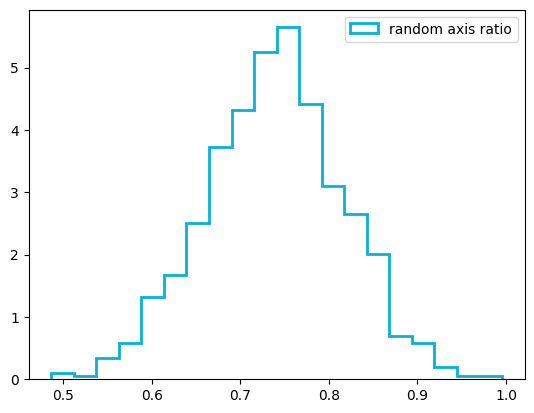

In [3]:
def qintr_prior(mu, sigma, num): # sample q_intr from truncated Gaussian prior
    lo_lim, hi_lim = 0, 1
    lo_transformed = (lo_lim - mu) / sigma
    hi_transformed = (hi_lim - mu) / sigma
    qintr_prior = truncnorm(lo_transformed, hi_transformed, loc = mu, scale = sigma)
    return qintr_prior.rvs(size = num)

if oblate:
    mu_qintr, sigma_qintr = 0.74, 0.08
else:
    mu_qintr, sigma_qintr = 0.84, 0.04


qintr_rm = qintr_prior(mu_qintr, sigma_qintr, 800)

plt.hist(qintr_rm, histtype='step', lw=2, label = 'random axis ratio', density = True, bins = 20)

plt.legend()
plt.show()

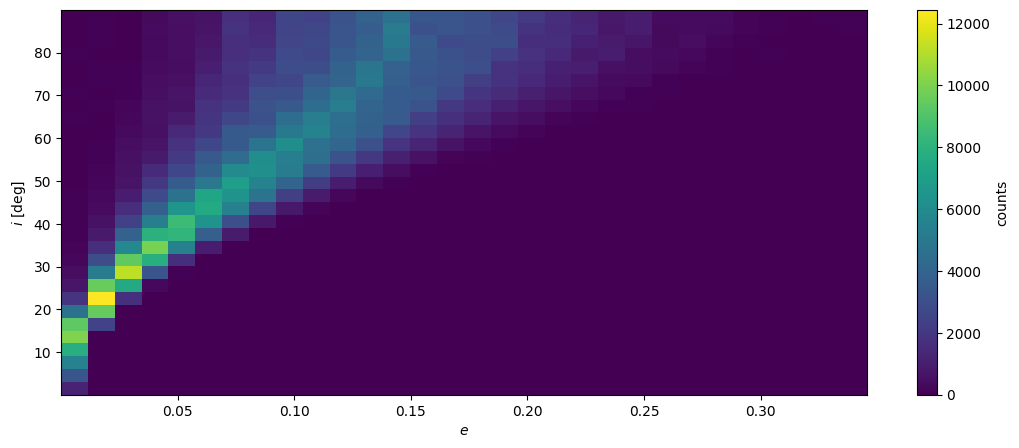

In [4]:
projection_axisym = Projection_axisym(qintr_rm) 

eobs_rm, inc_iso_rm = projection_axisym.Eobs_dist_iso_inc(plot_scatter=0, plot_2dhist=0, single_proj=1000, bins_2dhist_plot=[40, 30]) # test 

plt.figure(figsize = (13, 5))
hist, xedges, yedges = np.histogram2d(eobs_rm, np.degrees(inc_iso_rm), bins=30)
xcoord, ycoord = np.meshgrid(xedges, yedges)
plt.pcolormesh(xcoord, ycoord, hist.T)
plt.colorbar(label = 'counts')
# plt.xticks(np.arange(0, 0.6, 0.1))
plt.xlabel('$e$')
plt.ylabel('$i$ [deg]')
plt.show()

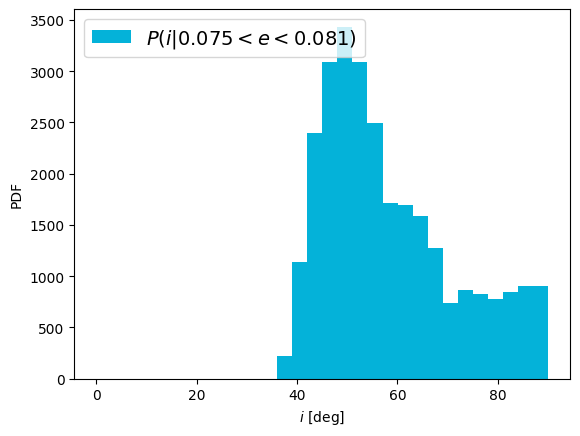

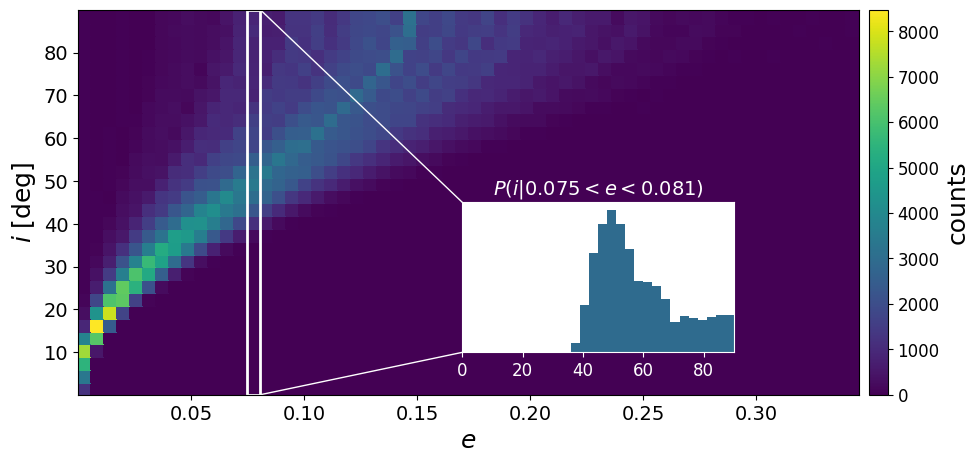

In [5]:
kwargs_eobs_iso_inc = {'single_proj': 1000, 'plot_2dhist': 0, 'bins_2dhist_plot': [30, 30], 'plot_scatter': 0}

e_example = 0.08 # here the observed ellipticity is 0.08
bins_2dhist = [60, 30]
hist, xedges, yedges = np.histogram2d(eobs_rm, np.degrees(inc_iso_rm), bins=bins_2dhist)
bin_ind = np.digitize(e_example, xedges) - 1

bins, counts = projection_axisym.Cond_pdf_inc_given_eobs(e_example, plot_1dpdf=0, bins_2dhist=bins_2dhist, normalize=0, **kwargs_eobs_iso_inc, quiet=1)

plt.figure()
plt.bar(np.degrees(bins[:-1]), counts, align='edge', width=np.diff(np.degrees(bins)), label = r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]))
plt.ylabel('PDF')
plt.xlabel('$i$ [deg]')
# plt.title(r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]))
plt.legend(prop = {'size': 14}, loc='upper left')
plt.show()


fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111)
xcoord, ycoord = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(xcoord, ycoord, hist.T)
pcm.set_edgecolor('face')
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
plot_width = np.diff(xedges)[0]
plot_height = y_max - y_min
rect = plt.Rectangle((xedges[bin_ind], y_min), plot_width, plot_height, fill=False, edgecolor='w', linewidth=2)
ax.add_patch(rect)
cbar = fig.colorbar(pcm, ax=ax, pad=0.01)
cbar.set_label('counts', size = 18)
# ax.set_xticks(np.arange(0, 0.6, 0.1))
plt.xlabel('$e$', size = 18)
plt.ylabel('$i$ [deg]', size = 18)
plt.xticks(size = 14)
plt.yticks(size = 14)
cbar.ax.tick_params(labelsize=12) 

# plot a slice of the histogram
insert_x0, insert_y0, insert_width, insert_height = 0.17, 10, 0.12, 35
insert_ax = ax.inset_axes([insert_x0, insert_y0, insert_width, insert_height], transform=ax.transData)
insert_ax.bar(np.degrees(bins[:-1]), counts, align='edge', width=np.diff(np.degrees(bins)), label = r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]), color='#2f6b8e')
# insert_ax.set_xlabel('$i$', c='w')
insert_ax.set(xticks=np.arange(0, 90, 20), yticks=[])
for spine in insert_ax.spines.values():
    spine.set_edgecolor('w')
insert_ax.xaxis.label.set_color('w')
insert_ax.tick_params(color='w', labelcolor='w', labelsize=12)
insert_ax.set_title(r'$P(i \vert {:.3f} < e < {:.3f})$' .format(xedges[bin_ind], xedges[bin_ind+1]), fontsize = 14, color='w')
insert_ax.set_xlim([0, 90])

# plot axis connecting the slice and the 1d histogram
ax.plot([xedges[bin_ind+1], insert_x0], [y_max, insert_y0 + insert_height], marker = ' ', ls = '-', lw=1, color='w')
ax.plot([xedges[bin_ind+1], insert_x0], [y_min, insert_y0], marker = ' ', ls = '-', lw=1, color='w')

# plt.savefig('./eobs_vs_inc_2dhist_{}.pdf' .format(oblate_name), bbox_inches='tight', dpi=300)

plt.show()

del e_example, bins, counts, hist, xedges, yedges


## Access mock data 

In [6]:
rerun_calculation = True

if not rerun_calculation:
    # load saved data
    with h5py.File('./kin_recovery_axisym_{}.hdf5' .format(oblate_name), 'r') as f:
        print(f.keys())
        inc_recover_all = f['inc_recover_all'][:]
        inc_recover_iso_all = f['inc_recover_iso_all'][:]
        vel_disp_all = f['vel_disp_all'][:]
        vel_disp_iso_all = f['vel_disp_iso_all'][:]
        inc_recover_sel = f['inc_recover_sel'][:]
        inc_recover_iso_sel = f['inc_recover_iso_sel'][:]
        vel_disp_sel = f['vel_disp_sel'][:]
        vel_disp_iso_sel = f['vel_disp_iso_sel'][:]

(600,)
(194,)


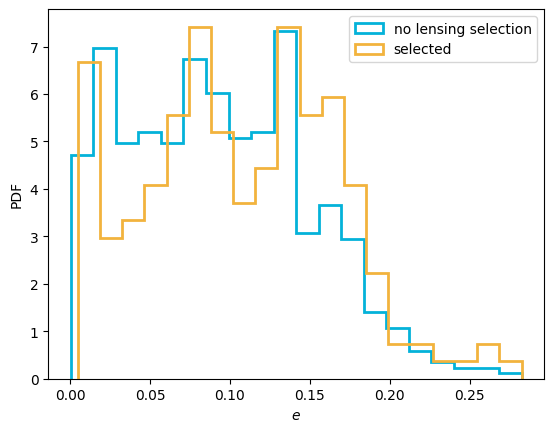

In [7]:
data = np.load('../fig5-fig6-make_kin_mock_data/kin_mock_data_{}.npy' .format(oblate_name))
data_copy = deepcopy(data)

qobs_data = data_copy[1, :]
theta_e_data = data_copy[0, :]
inc_data = data_copy[3, :]
sigma_e_data = data_copy[2, :]

if oblate:
    eobs_data = Axis_ratio2ellipticity(qobs_data)
else:
    eobs_data = -1 * Axis_ratio2ellipticity(qobs_data)
print(eobs_data.shape)

ind_sel = np.where(theta_e_data >= 1.2)[0]
eobs_data_sel = eobs_data[ind_sel]
qobs_data_sel = qobs_data[ind_sel]
inc_data_sel = inc_data[ind_sel]
sigma_e_data_sel = sigma_e_data[ind_sel]
print(eobs_data_sel.shape)

mean_sigma_e_data = np.mean(sigma_e_data)
mean_sigma_e_data_sel = np.mean(sigma_e_data_sel)

# plot data ellipticity
plt.figure()
plt.hist(eobs_data, bins = 20, label = 'no lensing selection', histtype='step', lw = 2, density=True)
plt.hist(eobs_data_sel, bins = 20, label = 'selected', histtype='step', lw = 2, density=True)
plt.legend(loc = 'best')
plt.xlabel('$e$')
plt.ylabel('PDF')
plt.show()

### Recover inclination angle from $P(i|e)$

#### The NO lensing selection sample

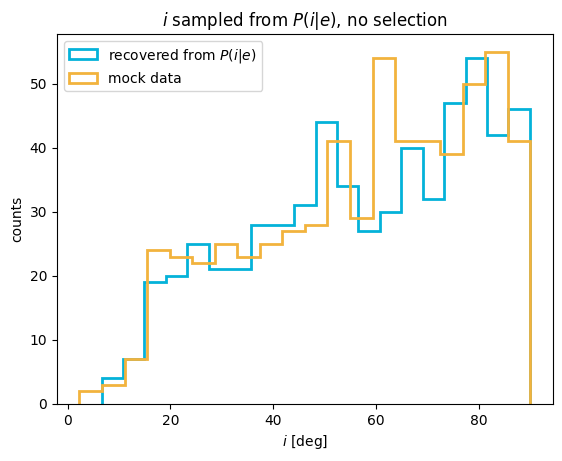

In [8]:
if rerun_calculation:
    inc_recover_all = projection_axisym.Recover_inclination(eobs_data, bins_2dhist=[60, 30], single_proj=1000)

plt.figure()
plt.hist(np.degrees(inc_recover_all), bins=20, label = r'recovered from $P(i\vert e)$', histtype='step', lw = 2)
plt.hist(inc_data, bins = 20, label = 'mock data', histtype='step', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title(r'$i$ sampled from $P(i|e)$, no selection')
plt.legend()
plt.show()

#### The lensing selected sample

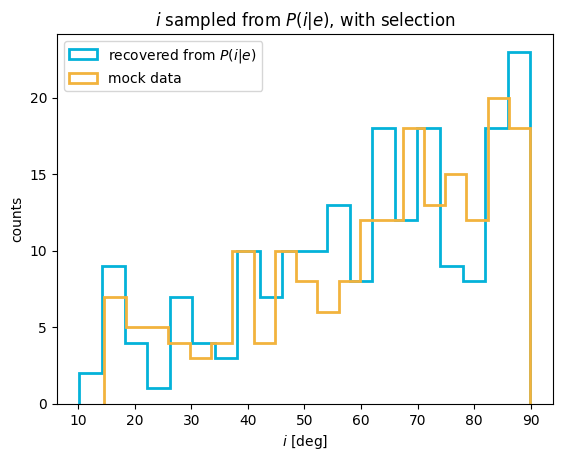

In [9]:
if rerun_calculation:
    inc_recover_sel = projection_axisym.Recover_inclination(eobs_data_sel, bins_2dhist=[60, 30], single_proj=1000)

plt.figure()
plt.hist(np.degrees(inc_recover_sel), bins=20, histtype='step', label = r'recovered from $P(i\vert e)$', lw = 2)
plt.hist(inc_data_sel, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title(r'$i$ sampled from $P(i|e)$, with selection')
plt.legend()
plt.show()

### Recover inclination angle from  isotropic distribution

#### The lensing selected sample

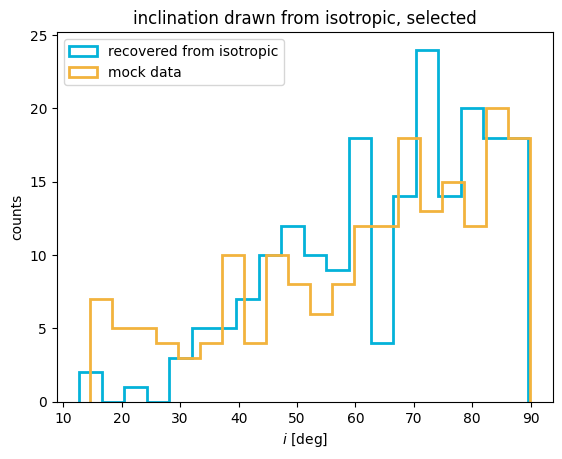

In [10]:
if rerun_calculation:
    inc_recover_iso_sel = projection_axisym.Recover_isotropic_inclination(eobs_data_sel)

plt.figure()
plt.hist(np.degrees(inc_recover_iso_sel), histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(inc_data_sel, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title('inclination drawn from isotropic, selected')
plt.legend()
plt.show()

#### The NO lensing selection sample

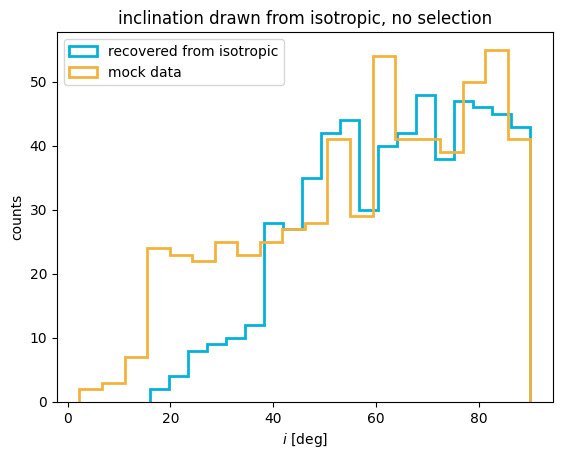

In [11]:
if rerun_calculation:
    inc_recover_iso_all = projection_axisym.Recover_isotropic_inclination(eobs_data)

plt.figure()
plt.hist(np.degrees(inc_recover_iso_all), histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(inc_data, bins = 20, histtype='step', label='mock data', lw = 2)
plt.xlabel('$i$ [deg]')
plt.ylabel('counts')
plt.title('inclination drawn from isotropic, no selection')
plt.legend()
plt.show()

## Recover the kinematics with JAM

In [12]:
# access projected MGE.
with h5py.File('../fig5-fig6-make_kin_mock_data/kin_mock_data_mge_{}.hdf5' .format(oblate_name), 'r') as f:
    print(f.keys())
    peak_den = f['peak_den'][:]
    peak_lum = f['peak_lum'][:]
    sigma_den = f['sigma_den'][:]
    sigma_lum = f['sigma_lum'][:]

peak_den_sel = peak_den[ind_sel]
sigma_den_sel = sigma_den[ind_sel]
peak_lum_sel = peak_lum[ind_sel]
sigma_lum_sel = sigma_lum[ind_sel]

<KeysViewHDF5 ['peak_den', 'peak_lum', 'sigma_den', 'sigma_lum']>


In [13]:
def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin):
    """calculate velocity dispersion within the half-light radius from a jam model

    Args:
        surf_lum (_type_): peak of surface luminosity MGE 
        sigma_lum (_type_): sigma of surface luminocity MGE
        qobs_lum (_type_): array of the projected axis raio of the surface luminosity MGEs
        jam (_type_): jam model, a jampy.jam_axi_proj instance
        xbin (_type_): x coordinate to sample the velocity dispersion
        ybin (_type_): y coordinate to sample the velocity dispersion
        plot_velmap (int, optional): whether to plot the velocity dispersion map. Defaults to 0.
        plot_sample_points (int, optional): whether to plot the xy coordinates within the half-light radius. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    ifu_dim = int(np.sqrt(len(xbin)))
    if np.all(qobs_lum <= 1):
        flux = jam.flux
    elif np.all(qobs_lum > 1):
        flux = np.reshape(jam.flux, (ifu_dim, ifu_dim)).T 
        flux = flux.flatten()
    else:
        raise ValueError('Apparent axis ratio must be constant with radius!')
    
    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)

    w = xbin**2 + ybin**2 < reff**2 

    model = jam.model

    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    print('sigma_e = {:.2f} km/s' .format(sig_e))

    return sig_e

In [14]:
lens_cosmo = get_default_lens_cosmo()
distance = lens_cosmo.Dd

In [15]:
def recover_vel_disp(peak_lum, sigma_lum, qobs_lum, peak_den, sigma_den, qobs_den, inclination, distance):
    """recover velocity dispersion from projected MGE components of the light and the mass

    Args:
        peak_lum (_type_): amplitude of the MGE describing the luminosity profile
        sigma_lum (_type_): dispersion of the MGE describing the luminosity profile
        qobs_lum (_type_): projected axis ratio of the MGE describing the luminosity profile
        peak_den (_type_): amplitude of the MGE describing the density profile
        sigma_den (_type_): dispersion of the MGE describing the density profile
        qobs_den (_type_): projected axis ratio of the MGE describing the density profile
        inclination (_type_): inclination angle
        distance (_type_): angular diameter distance to the system [Mpc]

    Returns:
        _type_: recovered velocity dispersion [km/s]
    """
    vel_disp = np.zeros(len(peak_den))
    inc_deg = np.degrees(inclination)
    for i in range(len(peak_den)):
        peak_lum_i = peak_lum[i]
        sigma_lum_i = sigma_lum[i]
        peak_den_i = peak_den[i]
        sigma_den_i = sigma_den[i]
        qobs_lum_i = qobs_lum[i]
        qobs_den_i = qobs_den[i]
        beta = np.zeros_like(peak_lum_i) # isotropic anisotropy

        if qobs_lum_i > 1:
            qobs_lum_i_apparent = 1 / qobs_lum_i # for Q>1, take the inverse to calculate reff
        else:
            qobs_lum_i_apparent = qobs_lum_i

        # set up a grid to perform jam 
        reff = mge_half_light_isophote(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i_apparent))[0]
        xx = np.linspace(-2.5 * reff, 2.5 * reff, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run jam
        jam = jam_axi_proj(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), peak_den_i, sigma_den_i, np.full_like(peak_den_i, qobs_den_i), inc_deg[i], 0, distance, xbin, ybin, plot=0, beta=beta, align='sph')
        # compute sigma_e
        sigma_e = get_sigma_e(peak_lum_i, sigma_lum_i, np.full_like(peak_lum_i, qobs_lum_i), jam, xbin, ybin)
        vel_disp[i] = sigma_e
        print(f"sigma_e: {sigma_e:.2f} km/s")

    return vel_disp

In [16]:
def percent_diff(a, b):
    return np.abs(a-b) / np.mean([a, b]) * 100

### With inclination angle recovered from $P(i|e$)
#### The lensing selected sample

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 261.38 km/s
sigma_e: 261.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 241.62 km/s
sigma_e: 241.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 261.99 km/s
sigma_e: 261.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.068e+14

sigma_e = 248.25 km/s
sigma_e: 248.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.254e+14

sigma_e = 273.24 km/s
sigma_e: 273.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.539e+14

sigma_e = 326.11 km/s
sigma_e: 326.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 237.46 km/s
sigma_e: 237.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 252.71 km/s
sigma_e: 252.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.372e+14

sigma_e = 277.73 km/s
sigma_e: 277.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 247.17 km/s
sigma_e: 247.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 274.16 km/s
sigma_e: 274.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 255.95 km/s
sigma_e: 255.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.075e+14

sigma_e = 255.71 km/s
sigma_e: 255.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 263.74 km/s
sigma_e: 263.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.015e+14

sigma_e = 249.23 km/s
sigma_e: 249.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 236.33 km/s
sigma_e: 236.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.724e+14

sigma_e = 274.62 km/s
sigma_e: 274.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 248.21 km/s
sigma_e: 248.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 251.01 km/s
sigma_e: 251.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 251.75 km/s
sigma_e: 251.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.886e+14

sigma_e = 302.48 km/s
sigma_e: 302.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 241.44 km/s
sigma_e: 241.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.398e+13

sigma_e = 253.95 km/s
sigma_e: 253.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 235.72 km/s
sigma_e: 235.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 235.00 km/s
sigma_e: 235.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 252.56 km/s
sigma_e: 252.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.195e+14

sigma_e = 270.99 km/s
sigma_e: 270.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.738e+13

sigma_e = 254.71 km/s
sigma_e: 254.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.364e+14

sigma_e = 279.58 km/s
sigma_e: 279.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.906e+13

sigma_e = 239.02 km/s
sigma_e: 239.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 250.90 km/s
sigma_e: 250.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 290.38 km/s
sigma_e: 290.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 242.27 km/s
sigma_e: 242.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.090e+14

sigma_e = 308.17 km/s
sigma_e: 308.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.660e+14

sigma_e = 293.28 km/s
sigma_e: 293.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.358e+14

sigma_e = 318.80 km/s
sigma_e: 318.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.463e+14

sigma_e = 324.42 km/s
sigma_e: 324.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.239e+14

sigma_e = 272.98 km/s
sigma_e: 272.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 277.29 km/s
sigma_e: 277.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.099e+14

sigma_e = 256.71 km/s
sigma_e: 256.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.156e+13

sigma_e = 236.47 km/s
sigma_e: 236.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.066e+13

sigma_e = 250.05 km/s
sigma_e: 250.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 293.78 km/s
sigma_e: 293.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 242.78 km/s
sigma_e: 242.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 240.97 km/s
sigma_e: 240.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.627e+13

sigma_e = 239.95 km/s
sigma_e: 239.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.307e+13

sigma_e = 249.96 km/s
sigma_e: 249.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.096e+13

sigma_e = 234.15 km/s
sigma_e: 234.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.645e+13

sigma_e = 255.39 km/s
sigma_e: 255.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 242.76 km/s
sigma_e: 242.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 232.14 km/s
sigma_e: 232.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 239.80 km/s
sigma_e: 239.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.928e+13

sigma_e = 256.14 km/s
sigma_e: 256.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 237.85 km/s
sigma_e: 237.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.051e+14

sigma_e = 299.17 km/s
sigma_e: 299.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.46 km/s
sigma_e: 273.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.088e+14

sigma_e = 262.86 km/s
sigma_e: 262.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.14 km/s
sigma_e: 247.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.707e+13

sigma_e = 255.57 km/s
sigma_e: 255.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.761e+14

sigma_e = 290.06 km/s
sigma_e: 290.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.340e+14

sigma_e = 278.81 km/s
sigma_e: 278.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 247.70 km/s
sigma_e: 247.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.360e+14

sigma_e = 277.28 km/s
sigma_e: 277.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 239.89 km/s
sigma_e: 239.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.533e+14

sigma_e = 285.64 km/s
sigma_e: 285.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 246.99 km/s
sigma_e: 246.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 239.56 km/s
sigma_e: 239.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 235.19 km/s
sigma_e: 235.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.396e+14

sigma_e = 275.68 km/s
sigma_e: 275.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.095e+14

sigma_e = 264.11 km/s
sigma_e: 264.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 270.10 km/s
sigma_e: 270.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 298.40 km/s
sigma_e: 298.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 266.79 km/s
sigma_e: 266.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.842e+14

sigma_e = 330.96 km/s
sigma_e: 330.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+14

sigma_e = 326.01 km/s
sigma_e: 326.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 244.54 km/s
sigma_e: 244.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 271.16 km/s
sigma_e: 271.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 255.22 km/s
sigma_e: 255.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 278.97 km/s
sigma_e: 278.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.155e+14

sigma_e = 267.72 km/s
sigma_e: 267.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.388e+14

sigma_e = 278.56 km/s
sigma_e: 278.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.084e+14

sigma_e = 311.79 km/s
sigma_e: 311.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.524e+14

sigma_e = 283.38 km/s
sigma_e: 283.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.485e+14

sigma_e = 284.51 km/s
sigma_e: 284.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 249.85 km/s
sigma_e: 249.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.865e+13

sigma_e = 255.18 km/s
sigma_e: 255.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.216e+13

sigma_e = 244.66 km/s
sigma_e: 244.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 251.33 km/s
sigma_e: 251.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.933e+14

sigma_e = 299.30 km/s
sigma_e: 299.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 245.14 km/s
sigma_e: 245.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.028e+14

sigma_e = 247.60 km/s
sigma_e: 247.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 270.60 km/s
sigma_e: 270.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=14.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 259.06 km/s
sigma_e: 259.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.948e+13

sigma_e = 251.50 km/s
sigma_e: 251.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 292.03 km/s
sigma_e: 292.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.281e+14

sigma_e = 268.13 km/s
sigma_e: 268.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.187e+14

sigma_e = 258.51 km/s
sigma_e: 258.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.80 km/s
sigma_e: 273.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+14

sigma_e = 275.08 km/s
sigma_e: 275.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+14

sigma_e = 276.72 km/s
sigma_e: 276.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.546e+14

sigma_e = 262.97 km/s
sigma_e: 262.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 288.89 km/s
sigma_e: 288.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.595e+14

sigma_e = 289.81 km/s
sigma_e: 289.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 268.30 km/s
sigma_e: 268.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.609e+14

sigma_e = 287.29 km/s
sigma_e: 287.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 265.38 km/s
sigma_e: 265.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.227e+14

sigma_e = 316.76 km/s
sigma_e: 316.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.007e+14

sigma_e = 341.12 km/s
sigma_e: 341.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.802e+13

sigma_e = 250.02 km/s
sigma_e: 250.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.490e+13

sigma_e = 255.90 km/s
sigma_e: 255.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.081e+13

sigma_e = 236.71 km/s
sigma_e: 236.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.007e+13

sigma_e = 237.35 km/s
sigma_e: 237.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 243.45 km/s
sigma_e: 243.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 240.17 km/s
sigma_e: 240.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.296e+14

sigma_e = 272.03 km/s
sigma_e: 272.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.007e+13

sigma_e = 247.65 km/s
sigma_e: 247.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 228.47 km/s
sigma_e: 228.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.266e+14

sigma_e = 264.12 km/s
sigma_e: 264.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.130e+14

sigma_e = 260.63 km/s
sigma_e: 260.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 283.93 km/s
sigma_e: 283.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.727e+14

sigma_e = 297.31 km/s
sigma_e: 297.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.041e+14

sigma_e = 251.68 km/s
sigma_e: 251.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 255.55 km/s
sigma_e: 255.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.169e+14

sigma_e = 256.04 km/s
sigma_e: 256.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 246.98 km/s
sigma_e: 246.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 248.01 km/s
sigma_e: 248.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 260.77 km/s
sigma_e: 260.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.707e+14

sigma_e = 295.12 km/s
sigma_e: 295.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.380e+14

sigma_e = 271.81 km/s
sigma_e: 271.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.861e+13

sigma_e = 232.40 km/s
sigma_e: 232.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 233.59 km/s
sigma_e: 233.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.551e+14

sigma_e = 283.65 km/s
sigma_e: 283.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.981e+14

sigma_e = 291.57 km/s
sigma_e: 291.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.766e+14

sigma_e = 290.63 km/s
sigma_e: 290.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.065e+14

sigma_e = 262.49 km/s
sigma_e: 262.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.112e+14

sigma_e = 292.44 km/s
sigma_e: 292.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 258.97 km/s
sigma_e: 258.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 308.58 km/s
sigma_e: 308.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 231.92 km/s
sigma_e: 231.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 240.63 km/s
sigma_e: 240.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 244.58 km/s
sigma_e: 244.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 249.03 km/s
sigma_e: 249.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 239.39 km/s
sigma_e: 239.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.958e+13

sigma_e = 236.72 km/s
sigma_e: 236.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 245.43 km/s
sigma_e: 245.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 241.10 km/s
sigma_e: 241.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.273e+14

sigma_e = 273.79 km/s
sigma_e: 273.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.009e+14

sigma_e = 256.64 km/s
sigma_e: 256.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.413e+14

sigma_e = 264.97 km/s
sigma_e: 264.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.309e+14

sigma_e = 319.24 km/s
sigma_e: 319.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.041e+13

sigma_e = 228.76 km/s
sigma_e: 228.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 286.35 km/s
sigma_e: 286.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 245.14 km/s
sigma_e: 245.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 239.65 km/s
sigma_e: 239.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 237.43 km/s
sigma_e: 237.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 270.77 km/s
sigma_e: 270.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.50 km/s
sigma_e: 247.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.614e+14

sigma_e = 292.32 km/s
sigma_e: 292.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 245.10 km/s
sigma_e: 245.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 244.05 km/s
sigma_e: 244.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 288.02 km/s
sigma_e: 288.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 236.07 km/s
sigma_e: 236.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=10.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.118e+14

sigma_e = 293.10 km/s
sigma_e: 293.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 250.89 km/s
sigma_e: 250.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 245.33 km/s
sigma_e: 245.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 256.99 km/s
sigma_e: 256.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.055e+14

sigma_e = 262.04 km/s
sigma_e: 262.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 241.98 km/s
sigma_e: 241.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+14

sigma_e = 293.24 km/s
sigma_e: 293.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.866e+14

sigma_e = 287.89 km/s
sigma_e: 287.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 246.67 km/s
sigma_e: 246.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 242.84 km/s
sigma_e: 242.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.019e+14

sigma_e = 256.86 km/s
sigma_e: 256.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.860e+13

sigma_e = 241.78 km/s
sigma_e: 241.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.751e+14

sigma_e = 296.34 km/s
sigma_e: 296.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+14

sigma_e = 272.58 km/s
sigma_e: 272.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.977e+13

sigma_e = 242.09 km/s
sigma_e: 242.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 257.57 km/s
sigma_e: 257.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 231.77 km/s
sigma_e: 231.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 244.36 km/s
sigma_e: 244.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 234.50 km/s
sigma_e: 234.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=14.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.113e+14

sigma_e = 237.21 km/s
sigma_e: 237.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 241.15 km/s
sigma_e: 241.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 269.83 km/s
sigma_e: 269.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.297e+14

sigma_e = 297.67 km/s
sigma_e: 297.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 306.24 km/s
sigma_e: 306.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 259.73 km/s
sigma_e: 259.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.76 km/s
sigma_e: 246.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 231.31 km/s
sigma_e: 231.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.434e+13

sigma_e = 237.89 km/s
sigma_e: 237.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 245.62 km/s
sigma_e: 245.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.133e+14

sigma_e = 331.35 km/s
sigma_e: 331.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.960e+13

sigma_e = 256.91 km/s
sigma_e: 256.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.618e+14

sigma_e = 290.06 km/s
sigma_e: 290.06 km/s


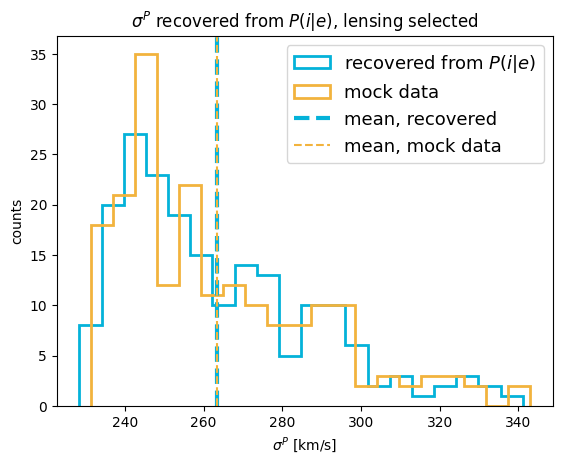

0.0710801808034058 %


In [17]:
if rerun_calculation:
    vel_disp_sel = recover_vel_disp(peak_lum_sel, sigma_lum_sel, qobs_data_sel, peak_den_sel, sigma_den_sel, qobs_data_sel, inc_recover_sel, distance)
mean_vel_disp_sel = np.mean(vel_disp_sel)

plt.figure()
plt.hist(vel_disp_sel, histtype='step', lw = 2, label = r'recovered from $P(i\vert e)$', bins=20)
plt.hist(sigma_e_data_sel, histtype='step', lw = 2, label = 'mock data', bins=20)
ax = plt.gca()
plt.axvline(mean_vel_disp_sel, marker = ' ', ls = '--', label = r'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data_sel, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from $P(i|e)$, lensing selected')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data_sel, mean_vel_disp_sel), '%')

#### The NO lensing selected sample

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.564e+13

sigma_e = 213.56 km/s
sigma_e: 213.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.126e+13

sigma_e = 232.14 km/s
sigma_e: 232.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 261.10 km/s
sigma_e: 261.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.716e+13

sigma_e = 187.07 km/s
sigma_e: 187.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 240.95 km/s
sigma_e: 240.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 260.56 km/s
sigma_e: 260.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.054e+13

sigma_e = 224.27 km/s
sigma_e: 224.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.605e+13

sigma_e = 216.88 km/s
sigma_e: 216.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.068e+14

sigma_e = 250.95 km/s
sigma_e: 250.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 230.11 km/s
sigma_e: 230.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 225.56 km/s
sigma_e: 225.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.254e+14

sigma_e = 273.23 km/s
sigma_e: 273.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 227.52 km/s
sigma_e: 227.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.710e+13

sigma_e = 225.28 km/s
sigma_e: 225.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.539e+14

sigma_e = 326.30 km/s
sigma_e: 326.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.889e+13

sigma_e = 188.94 km/s
sigma_e: 188.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 237.45 km/s
sigma_e: 237.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.077e+13

sigma_e = 139.71 km/s
sigma_e: 139.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.210e+13

sigma_e = 146.69 km/s
sigma_e: 146.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 253.52 km/s
sigma_e: 253.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.372e+14

sigma_e = 277.85 km/s
sigma_e: 277.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.566e+13

sigma_e = 207.45 km/s
sigma_e: 207.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 247.16 km/s
sigma_e: 247.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.638e+13

sigma_e = 163.77 km/s
sigma_e: 163.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 274.14 km/s
sigma_e: 274.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 255.55 km/s
sigma_e: 255.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.075e+14

sigma_e = 255.23 km/s
sigma_e: 255.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.914e+13

sigma_e = 188.01 km/s
sigma_e: 188.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 185.48 km/s
sigma_e: 185.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 263.78 km/s
sigma_e: 263.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.845e+13

sigma_e = 169.06 km/s
sigma_e: 169.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.680e+13

sigma_e = 175.96 km/s
sigma_e: 175.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.015e+14

sigma_e = 249.03 km/s
sigma_e: 249.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.124e+13

sigma_e = 215.57 km/s
sigma_e: 215.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 236.07 km/s
sigma_e: 236.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.314e+13

sigma_e = 196.48 km/s
sigma_e: 196.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.724e+14

sigma_e = 309.63 km/s
sigma_e: 309.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.131e+13

sigma_e = 172.42 km/s
sigma_e: 172.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.847e+13

sigma_e = 196.35 km/s
sigma_e: 196.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 248.06 km/s
sigma_e: 248.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.390e+13

sigma_e = 217.88 km/s
sigma_e: 217.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 251.20 km/s
sigma_e: 251.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.714e+13

sigma_e = 162.95 km/s
sigma_e: 162.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.088e+13

sigma_e = 192.96 km/s
sigma_e: 192.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.091e+13

sigma_e = 169.97 km/s
sigma_e: 169.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.597e+13

sigma_e = 158.42 km/s
sigma_e: 158.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 199.04 km/s
sigma_e: 199.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.814e+13

sigma_e = 185.93 km/s
sigma_e: 185.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 252.36 km/s
sigma_e: 252.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.886e+14

sigma_e = 302.15 km/s
sigma_e: 302.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+13

sigma_e = 150.65 km/s
sigma_e: 150.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 241.37 km/s
sigma_e: 241.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 230.86 km/s
sigma_e: 230.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.398e+13

sigma_e = 254.10 km/s
sigma_e: 254.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.680e+13

sigma_e = 158.45 km/s
sigma_e: 158.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 237.50 km/s
sigma_e: 237.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 242.17 km/s
sigma_e: 242.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.637e+13

sigma_e = 213.32 km/s
sigma_e: 213.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.816e+13

sigma_e = 199.56 km/s
sigma_e: 199.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 252.42 km/s
sigma_e: 252.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.382e+13

sigma_e = 151.84 km/s
sigma_e: 151.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.777e+13

sigma_e = 187.48 km/s
sigma_e: 187.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 219.34 km/s
sigma_e: 219.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e = 133.54 km/s
sigma_e: 133.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.599e+13

sigma_e = 233.66 km/s
sigma_e: 233.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.195e+14

sigma_e = 270.98 km/s
sigma_e: 270.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.605e+13

sigma_e = 223.85 km/s
sigma_e: 223.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.879e+13

sigma_e = 233.42 km/s
sigma_e: 233.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.464e+13

sigma_e = 154.27 km/s
sigma_e: 154.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.234e+13

sigma_e = 161.47 km/s
sigma_e: 161.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.085e+13

sigma_e = 204.88 km/s
sigma_e: 204.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.123e+13

sigma_e = 186.19 km/s
sigma_e: 186.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.738e+13

sigma_e = 257.24 km/s
sigma_e: 257.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.318e+13

sigma_e = 175.60 km/s
sigma_e: 175.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 200.29 km/s
sigma_e: 200.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.017e+13

sigma_e = 179.39 km/s
sigma_e: 179.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 196.12 km/s
sigma_e: 196.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.364e+14

sigma_e = 280.02 km/s
sigma_e: 280.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.882e+13

sigma_e = 170.62 km/s
sigma_e: 170.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.906e+13

sigma_e = 239.39 km/s
sigma_e: 239.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.770e+13

sigma_e = 199.19 km/s
sigma_e: 199.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 251.00 km/s
sigma_e: 251.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 291.56 km/s
sigma_e: 291.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.863e+13

sigma_e = 168.90 km/s
sigma_e: 168.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+13

sigma_e = 154.65 km/s
sigma_e: 154.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 142.10 km/s
sigma_e: 142.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 240.06 km/s
sigma_e: 240.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.272e+13

sigma_e = 192.02 km/s
sigma_e: 192.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 214.48 km/s
sigma_e: 214.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 213.94 km/s
sigma_e: 213.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.942e+13

sigma_e = 200.04 km/s
sigma_e: 200.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.154e+13

sigma_e = 205.88 km/s
sigma_e: 205.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.588e+13

sigma_e = 198.08 km/s
sigma_e: 198.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.909e+13

sigma_e = 215.90 km/s
sigma_e: 215.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.954e+12

sigma_e = 141.26 km/s
sigma_e: 141.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.863e+13

sigma_e = 200.50 km/s
sigma_e: 200.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 171.82 km/s
sigma_e: 171.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 224.22 km/s
sigma_e: 224.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 195.27 km/s
sigma_e: 195.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 232.19 km/s
sigma_e: 232.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.182e+13

sigma_e = 172.92 km/s
sigma_e: 172.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.090e+14

sigma_e = 308.28 km/s
sigma_e: 308.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.530e+13

sigma_e = 207.12 km/s
sigma_e: 207.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=9.61; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 219.03 km/s
sigma_e: 219.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.236e+12

sigma_e = 142.66 km/s
sigma_e: 142.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.692e+13

sigma_e = 212.58 km/s
sigma_e: 212.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.300e+13

sigma_e = 192.82 km/s
sigma_e: 192.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.660e+14

sigma_e = 292.83 km/s
sigma_e: 292.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.619e+13

sigma_e = 213.06 km/s
sigma_e: 213.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 196.05 km/s
sigma_e: 196.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.223e+13

sigma_e = 176.91 km/s
sigma_e: 176.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.358e+14

sigma_e = 316.62 km/s
sigma_e: 316.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.551e+13

sigma_e = 183.43 km/s
sigma_e: 183.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.692e+13

sigma_e = 183.02 km/s
sigma_e: 183.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.463e+14

sigma_e = 324.73 km/s
sigma_e: 324.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.515e+13

sigma_e = 196.48 km/s
sigma_e: 196.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.799e+13

sigma_e = 234.37 km/s
sigma_e: 234.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.239e+14

sigma_e = 273.00 km/s
sigma_e: 273.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 175.93 km/s
sigma_e: 175.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 219.48 km/s
sigma_e: 219.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.373e+13

sigma_e = 197.18 km/s
sigma_e: 197.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 218.87 km/s
sigma_e: 218.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.209e+13

sigma_e = 227.13 km/s
sigma_e: 227.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 273.66 km/s
sigma_e: 273.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.510e+13

sigma_e = 159.77 km/s
sigma_e: 159.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.099e+14

sigma_e = 256.05 km/s
sigma_e: 256.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.156e+13

sigma_e = 235.37 km/s
sigma_e: 235.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 213.55 km/s
sigma_e: 213.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.789e+13

sigma_e = 232.12 km/s
sigma_e: 232.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.923e+13

sigma_e = 227.14 km/s
sigma_e: 227.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.066e+13

sigma_e = 250.12 km/s
sigma_e: 250.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.109e+13

sigma_e = 187.98 km/s
sigma_e: 187.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.680e+13

sigma_e = 182.98 km/s
sigma_e: 182.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.380e+13

sigma_e = 210.53 km/s
sigma_e: 210.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 293.94 km/s
sigma_e: 293.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 161.91 km/s
sigma_e: 161.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 186.01 km/s
sigma_e: 186.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.325e+13

sigma_e = 151.03 km/s
sigma_e: 151.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 214.27 km/s
sigma_e: 214.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.098e+13

sigma_e = 225.77 km/s
sigma_e: 225.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 198.77 km/s
sigma_e: 198.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.802e+13

sigma_e = 211.63 km/s
sigma_e: 211.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 189.45 km/s
sigma_e: 189.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.286e+13

sigma_e = 196.10 km/s
sigma_e: 196.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 242.78 km/s
sigma_e: 242.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.573e+13

sigma_e = 192.89 km/s
sigma_e: 192.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 172.11 km/s
sigma_e: 172.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.799e+13

sigma_e = 225.97 km/s
sigma_e: 225.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=14.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.254e+13

sigma_e = 224.25 km/s
sigma_e: 224.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 208.39 km/s
sigma_e: 208.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 173.28 km/s
sigma_e: 173.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.131e+13

sigma_e = 232.10 km/s
sigma_e: 232.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 240.72 km/s
sigma_e: 240.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.627e+13

sigma_e = 238.36 km/s
sigma_e: 238.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.739e+13

sigma_e = 201.91 km/s
sigma_e: 201.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.307e+13

sigma_e = 249.97 km/s
sigma_e: 249.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.978e+13

sigma_e = 185.14 km/s
sigma_e: 185.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.101e+13

sigma_e = 158.09 km/s
sigma_e: 158.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.056e+13

sigma_e = 225.33 km/s
sigma_e: 225.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.261e+13

sigma_e = 220.43 km/s
sigma_e: 220.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.502e+13

sigma_e = 205.07 km/s
sigma_e: 205.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.096e+13

sigma_e = 232.62 km/s
sigma_e: 232.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.645e+13

sigma_e = 255.42 km/s
sigma_e: 255.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 221.42 km/s
sigma_e: 221.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 242.74 km/s
sigma_e: 242.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.223e+13

sigma_e = 150.06 km/s
sigma_e: 150.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.820e+13

sigma_e = 210.07 km/s
sigma_e: 210.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.482e+13

sigma_e = 211.17 km/s
sigma_e: 211.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 232.11 km/s
sigma_e: 232.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.528e+13

sigma_e = 170.97 km/s
sigma_e: 170.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.717e+13

sigma_e = 231.18 km/s
sigma_e: 231.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 239.80 km/s
sigma_e: 239.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.928e+13

sigma_e = 256.31 km/s
sigma_e: 256.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.879e+13

sigma_e = 201.29 km/s
sigma_e: 201.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 238.76 km/s
sigma_e: 238.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.709e+13

sigma_e = 193.12 km/s
sigma_e: 193.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.261e+13

sigma_e = 219.68 km/s
sigma_e: 219.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.259e+13

sigma_e = 192.67 km/s
sigma_e: 192.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 231.91 km/s
sigma_e: 231.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 219.10 km/s
sigma_e: 219.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.85
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.187e+13

sigma_e = 211.10 km/s
sigma_e: 211.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 209.57 km/s
sigma_e: 209.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.609e+13

sigma_e = 182.49 km/s
sigma_e: 182.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 188.69 km/s
sigma_e: 188.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.328e+13

sigma_e = 177.96 km/s
sigma_e: 177.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 200.01 km/s
sigma_e: 200.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.051e+14

sigma_e = 291.62 km/s
sigma_e: 291.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.958e+13

sigma_e = 196.42 km/s
sigma_e: 196.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 184.49 km/s
sigma_e: 184.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.618e+13

sigma_e = 200.74 km/s
sigma_e: 200.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.275e+13

sigma_e = 170.05 km/s
sigma_e: 170.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.724e+13

sigma_e = 202.09 km/s
sigma_e: 202.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.22 km/s
sigma_e: 273.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.088e+14

sigma_e = 263.22 km/s
sigma_e: 263.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 218.47 km/s
sigma_e: 218.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.837e+13

sigma_e = 225.95 km/s
sigma_e: 225.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.165e+13

sigma_e = 224.22 km/s
sigma_e: 224.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.023e+13

sigma_e = 204.29 km/s
sigma_e: 204.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.25 km/s
sigma_e: 247.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.707e+13

sigma_e = 257.22 km/s
sigma_e: 257.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.537e+13

sigma_e = 235.62 km/s
sigma_e: 235.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.761e+14

sigma_e = 290.98 km/s
sigma_e: 290.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.340e+14

sigma_e = 278.81 km/s
sigma_e: 278.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 248.60 km/s
sigma_e: 248.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.360e+14

sigma_e = 277.16 km/s
sigma_e: 277.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.529e+13

sigma_e = 188.16 km/s
sigma_e: 188.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.783e+13

sigma_e = 214.44 km/s
sigma_e: 214.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 239.82 km/s
sigma_e: 239.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.320e+13

sigma_e = 216.32 km/s
sigma_e: 216.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.630e+13

sigma_e = 162.85 km/s
sigma_e: 162.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.329e+13

sigma_e = 177.18 km/s
sigma_e: 177.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.052e+13

sigma_e = 170.03 km/s
sigma_e: 170.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.533e+14

sigma_e = 285.94 km/s
sigma_e: 285.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 188.59 km/s
sigma_e: 188.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 247.30 km/s
sigma_e: 247.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 185.66 km/s
sigma_e: 185.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.495e+13

sigma_e = 203.16 km/s
sigma_e: 203.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 240.91 km/s
sigma_e: 240.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 235.92 km/s
sigma_e: 235.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.396e+14

sigma_e = 279.25 km/s
sigma_e: 279.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.789e+13

sigma_e = 228.71 km/s
sigma_e: 228.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.845e+13

sigma_e = 165.12 km/s
sigma_e: 165.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.748e+13

sigma_e = 154.65 km/s
sigma_e: 154.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 166.92 km/s
sigma_e: 166.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.919e+13

sigma_e = 166.93 km/s
sigma_e: 166.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.095e+14

sigma_e = 264.39 km/s
sigma_e: 264.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 178.31 km/s
sigma_e: 178.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.801e+13

sigma_e = 186.85 km/s
sigma_e: 186.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.361e+13

sigma_e = 157.17 km/s
sigma_e: 157.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.965e+13

sigma_e = 171.95 km/s
sigma_e: 171.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.030e+13

sigma_e = 191.71 km/s
sigma_e: 191.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 269.05 km/s
sigma_e: 269.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 299.75 km/s
sigma_e: 299.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 265.32 km/s
sigma_e: 265.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.783e+13

sigma_e = 160.83 km/s
sigma_e: 160.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.895e+13

sigma_e = 213.31 km/s
sigma_e: 213.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.842e+14

sigma_e = 328.48 km/s
sigma_e: 328.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.383e+13

sigma_e = 178.10 km/s
sigma_e: 178.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.412e+13

sigma_e = 158.25 km/s
sigma_e: 158.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.170e+13

sigma_e = 204.90 km/s
sigma_e: 204.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+14

sigma_e = 318.64 km/s
sigma_e: 318.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.752e+13

sigma_e = 182.35 km/s
sigma_e: 182.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 247.62 km/s
sigma_e: 247.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.990e+13

sigma_e = 205.99 km/s
sigma_e: 205.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.810e+13

sigma_e = 168.99 km/s
sigma_e: 168.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.589e+13

sigma_e = 162.50 km/s
sigma_e: 162.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 224.73 km/s
sigma_e: 224.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.375e+13

sigma_e = 154.53 km/s
sigma_e: 154.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.280e+13

sigma_e = 219.02 km/s
sigma_e: 219.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=10.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 203.73 km/s
sigma_e: 203.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 269.74 km/s
sigma_e: 269.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 194.10 km/s
sigma_e: 194.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.329e+13

sigma_e = 172.44 km/s
sigma_e: 172.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.300e+13

sigma_e = 190.80 km/s
sigma_e: 190.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.277e+13

sigma_e = 230.25 km/s
sigma_e: 230.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 205.02 km/s
sigma_e: 205.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 254.79 km/s
sigma_e: 254.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.671e+13

sigma_e = 162.92 km/s
sigma_e: 162.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.342e+13

sigma_e = 194.34 km/s
sigma_e: 194.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.956e+13

sigma_e = 168.33 km/s
sigma_e: 168.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.513e+13

sigma_e = 210.26 km/s
sigma_e: 210.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.837e+13

sigma_e = 221.79 km/s
sigma_e: 221.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.965e+13

sigma_e = 182.74 km/s
sigma_e: 182.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.670e+13

sigma_e = 232.28 km/s
sigma_e: 232.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 279.05 km/s
sigma_e: 279.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.155e+14

sigma_e = 267.68 km/s
sigma_e: 267.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.814e+13

sigma_e = 188.03 km/s
sigma_e: 188.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.137e+13

sigma_e = 206.43 km/s
sigma_e: 206.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.443e+13

sigma_e = 207.53 km/s
sigma_e: 207.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.322e+13

sigma_e = 204.87 km/s
sigma_e: 204.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.388e+14

sigma_e = 277.20 km/s
sigma_e: 277.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.084e+14

sigma_e = 311.54 km/s
sigma_e: 311.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.524e+14

sigma_e = 284.85 km/s
sigma_e: 284.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.027e+13

sigma_e = 202.51 km/s
sigma_e: 202.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.485e+14

sigma_e = 282.83 km/s
sigma_e: 282.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 248.54 km/s
sigma_e: 248.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.765e+13

sigma_e = 164.70 km/s
sigma_e: 164.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.865e+13

sigma_e = 254.93 km/s
sigma_e: 254.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 222.26 km/s
sigma_e: 222.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.216e+13

sigma_e = 243.77 km/s
sigma_e: 243.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 216.32 km/s
sigma_e: 216.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.646e+13

sigma_e = 153.29 km/s
sigma_e: 153.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.599e+13

sigma_e = 225.05 km/s
sigma_e: 225.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 219.48 km/s
sigma_e: 219.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 219.87 km/s
sigma_e: 219.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 253.16 km/s
sigma_e: 253.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 218.35 km/s
sigma_e: 218.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.933e+14

sigma_e = 299.25 km/s
sigma_e: 299.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 245.54 km/s
sigma_e: 245.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.876e+13

sigma_e = 197.52 km/s
sigma_e: 197.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.028e+14

sigma_e = 247.73 km/s
sigma_e: 247.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 270.19 km/s
sigma_e: 270.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.891e+13

sigma_e = 170.32 km/s
sigma_e: 170.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 261.93 km/s
sigma_e: 261.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.939e+13

sigma_e = 189.35 km/s
sigma_e: 189.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 224.99 km/s
sigma_e: 224.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.300e+13

sigma_e = 220.46 km/s
sigma_e: 220.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 206.92 km/s
sigma_e: 206.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.471e+13

sigma_e = 183.75 km/s
sigma_e: 183.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 198.54 km/s
sigma_e: 198.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.948e+13

sigma_e = 251.65 km/s
sigma_e: 251.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 289.50 km/s
sigma_e: 289.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.425e+13

sigma_e = 206.61 km/s
sigma_e: 206.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 188.08 km/s
sigma_e: 188.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.281e+14

sigma_e = 269.33 km/s
sigma_e: 269.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.187e+14

sigma_e = 257.98 km/s
sigma_e: 257.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.142e+13

sigma_e = 228.85 km/s
sigma_e: 228.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.165e+13

sigma_e = 216.50 km/s
sigma_e: 216.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.419e+13

sigma_e = 142.03 km/s
sigma_e: 142.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.77 km/s
sigma_e: 273.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.901e+13

sigma_e = 183.72 km/s
sigma_e: 183.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+14

sigma_e = 275.04 km/s
sigma_e: 275.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.965e+13

sigma_e = 172.27 km/s
sigma_e: 172.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+14

sigma_e = 276.98 km/s
sigma_e: 276.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.880e+13

sigma_e = 213.48 km/s
sigma_e: 213.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.837e+13

sigma_e = 226.13 km/s
sigma_e: 226.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 224.03 km/s
sigma_e: 224.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.623e+13

sigma_e = 229.74 km/s
sigma_e: 229.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 200.44 km/s
sigma_e: 200.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.546e+14

sigma_e = 265.89 km/s
sigma_e: 265.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.036e+13

sigma_e = 145.88 km/s
sigma_e: 145.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.494e+13

sigma_e = 178.30 km/s
sigma_e: 178.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 209.79 km/s
sigma_e: 209.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 201.57 km/s
sigma_e: 201.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e = 219.89 km/s
sigma_e: 219.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 288.97 km/s
sigma_e: 288.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.595e+14

sigma_e = 289.85 km/s
sigma_e: 289.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.739e+13

sigma_e = 200.12 km/s
sigma_e: 200.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 268.41 km/s
sigma_e: 268.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.609e+14

sigma_e = 287.37 km/s
sigma_e: 287.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 263.67 km/s
sigma_e: 263.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.752e+13

sigma_e = 174.05 km/s
sigma_e: 174.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.217e+13

sigma_e = 195.37 km/s
sigma_e: 195.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.104e+13

sigma_e = 216.87 km/s
sigma_e: 216.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.254e+13

sigma_e = 202.61 km/s
sigma_e: 202.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 221.17 km/s
sigma_e: 221.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 219.33 km/s
sigma_e: 219.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.227e+14

sigma_e = 316.88 km/s
sigma_e: 316.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.970e+13

sigma_e = 210.10 km/s
sigma_e: 210.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.342e+13

sigma_e = 196.75 km/s
sigma_e: 196.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.007e+14

sigma_e = 341.12 km/s
sigma_e: 341.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 208.04 km/s
sigma_e: 208.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.030e+13

sigma_e = 141.77 km/s
sigma_e: 141.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.966e+13

sigma_e = 226.85 km/s
sigma_e: 226.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.299e+13

sigma_e = 229.41 km/s
sigma_e: 229.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 196.96 km/s
sigma_e: 196.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.836e+13

sigma_e = 167.87 km/s
sigma_e: 167.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.286e+13

sigma_e = 192.51 km/s
sigma_e: 192.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.668e+13

sigma_e = 185.49 km/s
sigma_e: 185.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.909e+13

sigma_e = 169.00 km/s
sigma_e: 169.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 214.34 km/s
sigma_e: 214.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.802e+13

sigma_e = 249.83 km/s
sigma_e: 249.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=8.53; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.062e+13

sigma_e = 170.91 km/s
sigma_e: 170.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.449e+13

sigma_e = 174.37 km/s
sigma_e: 174.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.490e+13

sigma_e = 255.94 km/s
sigma_e: 255.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.081e+13

sigma_e = 236.75 km/s
sigma_e: 236.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.007e+13

sigma_e = 237.23 km/s
sigma_e: 237.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 242.95 km/s
sigma_e: 242.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 240.57 km/s
sigma_e: 240.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.296e+14

sigma_e = 271.44 km/s
sigma_e: 271.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.007e+13

sigma_e = 245.49 km/s
sigma_e: 245.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 224.68 km/s
sigma_e: 224.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 233.83 km/s
sigma_e: 233.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.266e+14

sigma_e = 264.53 km/s
sigma_e: 264.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.130e+14

sigma_e = 260.14 km/s
sigma_e: 260.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.765e+13

sigma_e = 167.54 km/s
sigma_e: 167.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.205e+13

sigma_e = 227.94 km/s
sigma_e: 227.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.839e+13

sigma_e = 210.59 km/s
sigma_e: 210.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 281.04 km/s
sigma_e: 281.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.794e+13

sigma_e = 222.06 km/s
sigma_e: 222.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.951e+13

sigma_e = 216.04 km/s
sigma_e: 216.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.727e+14

sigma_e = 297.28 km/s
sigma_e: 297.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.041e+14

sigma_e = 253.28 km/s
sigma_e: 253.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 231.47 km/s
sigma_e: 231.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 255.53 km/s
sigma_e: 255.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.169e+14

sigma_e = 258.43 km/s
sigma_e: 258.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.449e+13

sigma_e = 158.04 km/s
sigma_e: 158.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.442e+13

sigma_e = 198.59 km/s
sigma_e: 198.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e = 158.07 km/s
sigma_e: 158.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.544e+13

sigma_e = 199.84 km/s
sigma_e: 199.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 167.92 km/s
sigma_e: 167.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.827e+13

sigma_e = 162.10 km/s
sigma_e: 162.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 247.03 km/s
sigma_e: 247.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.139e+13

sigma_e = 147.46 km/s
sigma_e: 147.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 248.06 km/s
sigma_e: 248.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 260.45 km/s
sigma_e: 260.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.479e+13

sigma_e = 160.10 km/s
sigma_e: 160.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=12.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.314e+13

sigma_e = 180.49 km/s
sigma_e: 180.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.707e+14

sigma_e = 295.16 km/s
sigma_e: 295.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.928e+13

sigma_e = 163.82 km/s
sigma_e: 163.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=6.61; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.350e+13

sigma_e = 165.18 km/s
sigma_e: 165.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.380e+14

sigma_e = 272.91 km/s
sigma_e: 272.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.792e+13

sigma_e = 167.73 km/s
sigma_e: 167.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.861e+13

sigma_e = 232.64 km/s
sigma_e: 232.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 233.20 km/s
sigma_e: 233.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 220.27 km/s
sigma_e: 220.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.203e+13

sigma_e = 205.33 km/s
sigma_e: 205.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.551e+14

sigma_e = 287.86 km/s
sigma_e: 287.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.633e+13

sigma_e = 195.99 km/s
sigma_e: 195.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.096e+13

sigma_e = 176.89 km/s
sigma_e: 176.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.981e+14

sigma_e = 294.49 km/s
sigma_e: 294.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.237e+13

sigma_e = 204.83 km/s
sigma_e: 204.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.754e+13

sigma_e = 198.14 km/s
sigma_e: 198.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.104e+13

sigma_e = 207.85 km/s
sigma_e: 207.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.589e+13

sigma_e = 162.47 km/s
sigma_e: 162.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.766e+14

sigma_e = 296.00 km/s
sigma_e: 296.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.065e+14

sigma_e = 262.42 km/s
sigma_e: 262.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.237e+13

sigma_e = 206.65 km/s
sigma_e: 206.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.548e+13

sigma_e = 209.04 km/s
sigma_e: 209.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.552e+13

sigma_e = 229.14 km/s
sigma_e: 229.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 232.14 km/s
sigma_e: 232.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.41
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.622e+13

sigma_e = 163.96 km/s
sigma_e: 163.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.574e+13

sigma_e = 183.94 km/s
sigma_e: 183.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 180.98 km/s
sigma_e: 180.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.112e+14

sigma_e = 289.60 km/s
sigma_e: 289.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.98
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.597e+13

sigma_e = 156.98 km/s
sigma_e: 156.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 218.38 km/s
sigma_e: 218.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.372e+13

sigma_e = 170.06 km/s
sigma_e: 170.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 258.96 km/s
sigma_e: 258.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 146.24 km/s
sigma_e: 146.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 198.90 km/s
sigma_e: 198.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 309.43 km/s
sigma_e: 309.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 231.93 km/s
sigma_e: 231.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 240.68 km/s
sigma_e: 240.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 244.59 km/s
sigma_e: 244.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 172.76 km/s
sigma_e: 172.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.937e+13

sigma_e = 160.64 km/s
sigma_e: 160.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 246.82 km/s
sigma_e: 246.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.091e+13

sigma_e = 172.35 km/s
sigma_e: 172.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 239.08 km/s
sigma_e: 239.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.356e+13

sigma_e = 208.83 km/s
sigma_e: 208.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.452e+12

sigma_e = 140.95 km/s
sigma_e: 140.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.958e+13

sigma_e = 236.55 km/s
sigma_e: 236.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.537e+13

sigma_e = 232.74 km/s
sigma_e: 232.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 249.35 km/s
sigma_e: 249.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.01
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 241.10 km/s
sigma_e: 241.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e = 173.65 km/s
sigma_e: 173.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 230.85 km/s
sigma_e: 230.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 151.41 km/s
sigma_e: 151.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.273e+14

sigma_e = 275.20 km/s
sigma_e: 275.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.792e+13

sigma_e = 168.06 km/s
sigma_e: 168.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.009e+14

sigma_e = 257.13 km/s
sigma_e: 257.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.566e+13

sigma_e = 201.64 km/s
sigma_e: 201.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.413e+14

sigma_e = 260.07 km/s
sigma_e: 260.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.740e+13

sigma_e = 178.23 km/s
sigma_e: 178.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.746e+13

sigma_e = 232.22 km/s
sigma_e: 232.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 211.92 km/s
sigma_e: 211.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.958e+13

sigma_e = 205.55 km/s
sigma_e: 205.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.032e+13

sigma_e = 221.40 km/s
sigma_e: 221.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.309e+14

sigma_e = 319.34 km/s
sigma_e: 319.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=12.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.618e+13

sigma_e = 184.72 km/s
sigma_e: 184.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.180e+13

sigma_e = 232.69 km/s
sigma_e: 232.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+13

sigma_e = 148.08 km/s
sigma_e: 148.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.041e+13

sigma_e = 219.50 km/s
sigma_e: 219.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 229.61 km/s
sigma_e: 229.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.101e+13

sigma_e = 169.00 km/s
sigma_e: 169.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.774e+13

sigma_e = 167.07 km/s
sigma_e: 167.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 287.39 km/s
sigma_e: 287.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 220.24 km/s
sigma_e: 220.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 245.06 km/s
sigma_e: 245.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.731e+13

sigma_e = 149.19 km/s
sigma_e: 149.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.626e+13

sigma_e = 220.59 km/s
sigma_e: 220.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 239.90 km/s
sigma_e: 239.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 237.76 km/s
sigma_e: 237.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 270.77 km/s
sigma_e: 270.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 246.77 km/s
sigma_e: 246.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.328e+13

sigma_e = 188.92 km/s
sigma_e: 188.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.626e+13

sigma_e = 223.15 km/s
sigma_e: 223.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 204.09 km/s
sigma_e: 204.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.368e+13

sigma_e = 153.99 km/s
sigma_e: 153.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.614e+14

sigma_e = 292.08 km/s
sigma_e: 292.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 244.40 km/s
sigma_e: 244.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 244.89 km/s
sigma_e: 244.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.622e+13

sigma_e = 162.96 km/s
sigma_e: 162.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.994e+13

sigma_e = 169.95 km/s
sigma_e: 169.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 217.63 km/s
sigma_e: 217.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 175.73 km/s
sigma_e: 175.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 290.94 km/s
sigma_e: 290.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.544e+13

sigma_e = 198.94 km/s
sigma_e: 198.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.182e+13

sigma_e = 170.06 km/s
sigma_e: 170.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 235.40 km/s
sigma_e: 235.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 159.74 km/s
sigma_e: 159.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.619e+13

sigma_e = 213.61 km/s
sigma_e: 213.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.209e+13

sigma_e = 223.79 km/s
sigma_e: 223.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=14.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.118e+14

sigma_e = 303.40 km/s
sigma_e: 303.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.394e+13

sigma_e = 177.33 km/s
sigma_e: 177.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.678e+13

sigma_e = 197.26 km/s
sigma_e: 197.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.046e+13

sigma_e = 206.29 km/s
sigma_e: 206.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.472e+13

sigma_e = 160.43 km/s
sigma_e: 160.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 225.61 km/s
sigma_e: 225.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.772e+13

sigma_e = 174.89 km/s
sigma_e: 174.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 221.65 km/s
sigma_e: 221.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.777e+13

sigma_e = 172.14 km/s
sigma_e: 172.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 253.12 km/s
sigma_e: 253.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.345e+13

sigma_e = 219.22 km/s
sigma_e: 219.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 245.29 km/s
sigma_e: 245.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 257.15 km/s
sigma_e: 257.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.187e+13

sigma_e = 213.74 km/s
sigma_e: 213.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.863e+13

sigma_e = 197.31 km/s
sigma_e: 197.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.332e+13

sigma_e = 153.61 km/s
sigma_e: 153.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.586e+13

sigma_e = 177.90 km/s
sigma_e: 177.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.551e+13

sigma_e = 180.87 km/s
sigma_e: 180.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.913e+13

sigma_e = 211.06 km/s
sigma_e: 211.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.449e+13

sigma_e = 179.71 km/s
sigma_e: 179.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.055e+14

sigma_e = 262.90 km/s
sigma_e: 262.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.354e+13

sigma_e = 154.22 km/s
sigma_e: 154.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 241.61 km/s
sigma_e: 241.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.436e+13

sigma_e = 229.67 km/s
sigma_e: 229.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 224.97 km/s
sigma_e: 224.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+14

sigma_e = 293.34 km/s
sigma_e: 293.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.820e+13

sigma_e = 215.68 km/s
sigma_e: 215.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.866e+14

sigma_e = 288.42 km/s
sigma_e: 288.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 246.63 km/s
sigma_e: 246.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 202.75 km/s
sigma_e: 202.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 243.49 km/s
sigma_e: 243.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 232.76 km/s
sigma_e: 232.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 209.00 km/s
sigma_e: 209.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.245e+13

sigma_e = 184.28 km/s
sigma_e: 184.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.176e+13

sigma_e = 187.69 km/s
sigma_e: 187.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.241e+13

sigma_e = 206.25 km/s
sigma_e: 206.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.055e+13

sigma_e = 206.89 km/s
sigma_e: 206.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.85
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.836e+13

sigma_e = 164.51 km/s
sigma_e: 164.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.876e+13

sigma_e = 214.76 km/s
sigma_e: 214.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.019e+14

sigma_e = 256.83 km/s
sigma_e: 256.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.860e+13

sigma_e = 246.05 km/s
sigma_e: 246.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.751e+14

sigma_e = 296.75 km/s
sigma_e: 296.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+14

sigma_e = 272.58 km/s
sigma_e: 272.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 204.43 km/s
sigma_e: 204.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.056e+13

sigma_e = 191.95 km/s
sigma_e: 191.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 225.46 km/s
sigma_e: 225.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 179.26 km/s
sigma_e: 179.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.526e+13

sigma_e = 155.05 km/s
sigma_e: 155.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 184.48 km/s
sigma_e: 184.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.977e+13

sigma_e = 242.95 km/s
sigma_e: 242.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 257.29 km/s
sigma_e: 257.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=18.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.614e+13

sigma_e = 209.15 km/s
sigma_e: 209.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.083e+13

sigma_e = 148.10 km/s
sigma_e: 148.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.286e+13

sigma_e = 175.75 km/s
sigma_e: 175.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=17.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 236.22 km/s
sigma_e: 236.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.978e+13

sigma_e = 181.38 km/s
sigma_e: 181.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.802e+13

sigma_e = 202.13 km/s
sigma_e: 202.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 200.48 km/s
sigma_e: 200.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 244.33 km/s
sigma_e: 244.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.123e+13

sigma_e = 190.43 km/s
sigma_e: 190.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.895e+13

sigma_e = 204.58 km/s
sigma_e: 204.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.710e+13

sigma_e = 213.29 km/s
sigma_e: 213.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.574e+13

sigma_e = 183.33 km/s
sigma_e: 183.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.442e+13

sigma_e = 197.74 km/s
sigma_e: 197.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.143e+13

sigma_e = 215.97 km/s
sigma_e: 215.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.991e+13

sigma_e = 181.45 km/s
sigma_e: 181.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.668e+13

sigma_e = 185.38 km/s
sigma_e: 185.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.013e+13

sigma_e = 173.32 km/s
sigma_e: 173.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 208.20 km/s
sigma_e: 208.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.460e+13

sigma_e = 182.00 km/s
sigma_e: 182.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.602e+13

sigma_e = 197.18 km/s
sigma_e: 197.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.552e+13

sigma_e = 228.08 km/s
sigma_e: 228.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 234.32 km/s
sigma_e: 234.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.515e+13

sigma_e = 188.26 km/s
sigma_e: 188.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.970e+13

sigma_e = 216.95 km/s
sigma_e: 216.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.170e+13

sigma_e = 206.47 km/s
sigma_e: 206.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.004e+13

sigma_e = 190.42 km/s
sigma_e: 190.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.543e+13

sigma_e = 223.73 km/s
sigma_e: 223.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.774e+13

sigma_e = 167.50 km/s
sigma_e: 167.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.818e+13

sigma_e = 162.26 km/s
sigma_e: 162.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.210e+13

sigma_e = 147.13 km/s
sigma_e: 147.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.588e+13

sigma_e = 197.29 km/s
sigma_e: 197.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.428e+13

sigma_e = 181.95 km/s
sigma_e: 181.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 230.30 km/s
sigma_e: 230.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=12.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.113e+14

sigma_e = 225.74 km/s
sigma_e: 225.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 222.09 km/s
sigma_e: 222.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.202e+13

sigma_e = 215.96 km/s
sigma_e: 215.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.584e+13

sigma_e = 209.16 km/s
sigma_e: 209.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 244.45 km/s
sigma_e: 244.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.901e+13

sigma_e = 185.14 km/s
sigma_e: 185.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.320e+13

sigma_e = 218.45 km/s
sigma_e: 218.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 269.59 km/s
sigma_e: 269.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.559e+13

sigma_e = 197.88 km/s
sigma_e: 197.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 184.55 km/s
sigma_e: 184.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.704e+13

sigma_e = 185.84 km/s
sigma_e: 185.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.297e+14

sigma_e = 296.48 km/s
sigma_e: 296.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.104e+13

sigma_e = 206.05 km/s
sigma_e: 206.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.901e+13

sigma_e = 226.13 km/s
sigma_e: 226.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.773e+13

sigma_e = 215.65 km/s
sigma_e: 215.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 214.63 km/s
sigma_e: 214.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.143e+13

sigma_e = 219.20 km/s
sigma_e: 219.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 304.67 km/s
sigma_e: 304.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 258.81 km/s
sigma_e: 258.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 175.57 km/s
sigma_e: 175.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.731e+13

sigma_e = 163.83 km/s
sigma_e: 163.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.74 km/s
sigma_e: 246.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.485e+13

sigma_e = 196.43 km/s
sigma_e: 196.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 231.34 km/s
sigma_e: 231.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.434e+13

sigma_e = 238.64 km/s
sigma_e: 238.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 245.62 km/s
sigma_e: 245.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.85
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=15.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.133e+14

sigma_e = 332.62 km/s
sigma_e: 332.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.960e+13

sigma_e = 256.97 km/s
sigma_e: 256.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 229.35 km/s
sigma_e: 229.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.277e+13

sigma_e = 211.52 km/s
sigma_e: 211.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 192.84 km/s
sigma_e: 192.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.618e+14

sigma_e = 291.11 km/s
sigma_e: 291.11 km/s


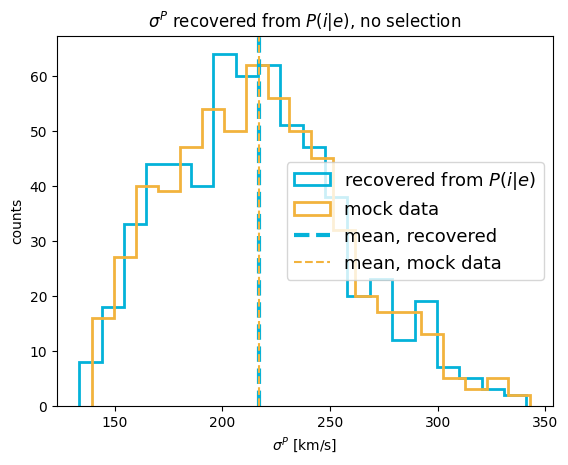

0.0010869442472979547 %


In [18]:
if rerun_calculation:
    vel_disp_all = recover_vel_disp(peak_lum, sigma_lum, qobs_data, peak_den, sigma_den, qobs_data, inc_recover_all, distance) 
mean_vel_disp_no_sel = np.mean(vel_disp_all)

plt.figure()
plt.hist(vel_disp_all, histtype='step', lw = 2, label = r'recovered from $P(i\vert e)$', bins=20)
plt.hist(sigma_e_data, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_no_sel, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from $P(i|e)$, no selection')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data, mean_vel_disp_no_sel), '%')

### With inclination angle recovered from isotropic

#### The lensing selected sample

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 261.29 km/s
sigma_e: 261.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 243.36 km/s
sigma_e: 243.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 258.48 km/s
sigma_e: 258.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=12.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.068e+14

sigma_e = 242.16 km/s
sigma_e: 242.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.254e+14

sigma_e = 272.29 km/s
sigma_e: 272.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.539e+14

sigma_e = 317.91 km/s
sigma_e: 317.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.85
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 237.34 km/s
sigma_e: 237.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 252.43 km/s
sigma_e: 252.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.372e+14

sigma_e = 277.53 km/s
sigma_e: 277.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 247.19 km/s
sigma_e: 247.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 273.89 km/s
sigma_e: 273.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 255.66 km/s
sigma_e: 255.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.075e+14

sigma_e = 256.99 km/s
sigma_e: 256.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 263.64 km/s
sigma_e: 263.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.015e+14

sigma_e = 249.01 km/s
sigma_e: 249.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 230.73 km/s
sigma_e: 230.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.724e+14

sigma_e = 327.74 km/s
sigma_e: 327.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 249.47 km/s
sigma_e: 249.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 251.49 km/s
sigma_e: 251.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 253.20 km/s
sigma_e: 253.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.886e+14

sigma_e = 302.46 km/s
sigma_e: 302.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 242.22 km/s
sigma_e: 242.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.398e+13

sigma_e = 253.95 km/s
sigma_e: 253.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 236.19 km/s
sigma_e: 236.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 240.37 km/s
sigma_e: 240.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 251.92 km/s
sigma_e: 251.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.195e+14

sigma_e = 270.21 km/s
sigma_e: 270.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.738e+13

sigma_e = 257.61 km/s
sigma_e: 257.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.364e+14

sigma_e = 259.74 km/s
sigma_e: 259.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.906e+13

sigma_e = 239.31 km/s
sigma_e: 239.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 250.58 km/s
sigma_e: 250.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 291.56 km/s
sigma_e: 291.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 240.45 km/s
sigma_e: 240.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.090e+14

sigma_e = 306.36 km/s
sigma_e: 306.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.660e+14

sigma_e = 293.13 km/s
sigma_e: 293.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.358e+14

sigma_e = 319.38 km/s
sigma_e: 319.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.463e+14

sigma_e = 306.49 km/s
sigma_e: 306.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.239e+14

sigma_e = 273.01 km/s
sigma_e: 273.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 271.97 km/s
sigma_e: 271.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.099e+14

sigma_e = 256.71 km/s
sigma_e: 256.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.156e+13

sigma_e = 235.39 km/s
sigma_e: 235.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.066e+13

sigma_e = 250.84 km/s
sigma_e: 250.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 293.97 km/s
sigma_e: 293.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 242.78 km/s
sigma_e: 242.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 240.99 km/s
sigma_e: 240.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.627e+13

sigma_e = 244.83 km/s
sigma_e: 244.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.307e+13

sigma_e = 249.96 km/s
sigma_e: 249.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.096e+13

sigma_e = 240.20 km/s
sigma_e: 240.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.645e+13

sigma_e = 253.61 km/s
sigma_e: 253.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 243.84 km/s
sigma_e: 243.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 232.10 km/s
sigma_e: 232.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 239.59 km/s
sigma_e: 239.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.928e+13

sigma_e = 256.20 km/s
sigma_e: 256.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 238.69 km/s
sigma_e: 238.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.051e+14

sigma_e = 300.13 km/s
sigma_e: 300.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 274.28 km/s
sigma_e: 274.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.088e+14

sigma_e = 258.80 km/s
sigma_e: 258.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.26 km/s
sigma_e: 247.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.707e+13

sigma_e = 257.43 km/s
sigma_e: 257.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.761e+14

sigma_e = 286.60 km/s
sigma_e: 286.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.340e+14

sigma_e = 278.76 km/s
sigma_e: 278.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 240.52 km/s
sigma_e: 240.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.360e+14

sigma_e = 275.94 km/s
sigma_e: 275.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 238.16 km/s
sigma_e: 238.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.533e+14

sigma_e = 284.27 km/s
sigma_e: 284.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.90
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 243.74 km/s
sigma_e: 243.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 243.85 km/s
sigma_e: 243.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 235.37 km/s
sigma_e: 235.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.396e+14

sigma_e = 281.70 km/s
sigma_e: 281.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.095e+14

sigma_e = 264.41 km/s
sigma_e: 264.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=22.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 270.15 km/s
sigma_e: 270.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 302.68 km/s
sigma_e: 302.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 265.70 km/s
sigma_e: 265.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.842e+14

sigma_e = 324.39 km/s
sigma_e: 324.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+14

sigma_e = 327.13 km/s
sigma_e: 327.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 249.59 km/s
sigma_e: 249.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 271.16 km/s
sigma_e: 271.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 256.89 km/s
sigma_e: 256.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.88
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 280.82 km/s
sigma_e: 280.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.155e+14

sigma_e = 267.73 km/s
sigma_e: 267.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.388e+14

sigma_e = 280.49 km/s
sigma_e: 280.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.084e+14

sigma_e = 311.69 km/s
sigma_e: 311.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.524e+14

sigma_e = 284.87 km/s
sigma_e: 284.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.485e+14

sigma_e = 284.46 km/s
sigma_e: 284.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 249.81 km/s
sigma_e: 249.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.865e+13

sigma_e = 254.71 km/s
sigma_e: 254.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.216e+13

sigma_e = 245.22 km/s
sigma_e: 245.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 254.20 km/s
sigma_e: 254.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.933e+14

sigma_e = 292.54 km/s
sigma_e: 292.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 246.65 km/s
sigma_e: 246.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.028e+14

sigma_e = 241.06 km/s
sigma_e: 241.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 264.81 km/s
sigma_e: 264.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 271.89 km/s
sigma_e: 271.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.948e+13

sigma_e = 249.44 km/s
sigma_e: 249.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 292.04 km/s
sigma_e: 292.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.281e+14

sigma_e = 269.42 km/s
sigma_e: 269.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.187e+14

sigma_e = 263.86 km/s
sigma_e: 263.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.77 km/s
sigma_e: 273.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+14

sigma_e = 275.04 km/s
sigma_e: 275.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+14

sigma_e = 274.23 km/s
sigma_e: 274.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.546e+14

sigma_e = 272.58 km/s
sigma_e: 272.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.87
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 287.08 km/s
sigma_e: 287.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.595e+14

sigma_e = 290.15 km/s
sigma_e: 290.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 268.22 km/s
sigma_e: 268.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.609e+14

sigma_e = 287.39 km/s
sigma_e: 287.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 267.93 km/s
sigma_e: 267.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.227e+14

sigma_e = 316.78 km/s
sigma_e: 316.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.007e+14

sigma_e = 340.60 km/s
sigma_e: 340.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.802e+13

sigma_e = 250.36 km/s
sigma_e: 250.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.490e+13

sigma_e = 255.96 km/s
sigma_e: 255.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.081e+13

sigma_e = 229.67 km/s
sigma_e: 229.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.007e+13

sigma_e = 236.88 km/s
sigma_e: 236.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 243.25 km/s
sigma_e: 243.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 238.95 km/s
sigma_e: 238.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.296e+14

sigma_e = 272.11 km/s
sigma_e: 272.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.007e+13

sigma_e = 247.18 km/s
sigma_e: 247.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 238.79 km/s
sigma_e: 238.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=13.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.266e+14

sigma_e = 260.78 km/s
sigma_e: 260.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.130e+14

sigma_e = 259.45 km/s
sigma_e: 259.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 284.89 km/s
sigma_e: 284.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.727e+14

sigma_e = 297.28 km/s
sigma_e: 297.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.041e+14

sigma_e = 255.89 km/s
sigma_e: 255.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 254.76 km/s
sigma_e: 254.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.169e+14

sigma_e = 262.61 km/s
sigma_e: 262.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 247.03 km/s
sigma_e: 247.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.58 km/s
sigma_e: 246.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 261.19 km/s
sigma_e: 261.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.707e+14

sigma_e = 296.67 km/s
sigma_e: 296.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.380e+14

sigma_e = 272.69 km/s
sigma_e: 272.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.861e+13

sigma_e = 232.53 km/s
sigma_e: 232.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 232.49 km/s
sigma_e: 232.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.551e+14

sigma_e = 289.22 km/s
sigma_e: 289.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.981e+14

sigma_e = 296.41 km/s
sigma_e: 296.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.766e+14

sigma_e = 295.85 km/s
sigma_e: 295.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.065e+14

sigma_e = 258.19 km/s
sigma_e: 258.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.112e+14

sigma_e = 292.94 km/s
sigma_e: 292.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 258.84 km/s
sigma_e: 258.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 292.28 km/s
sigma_e: 292.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 231.64 km/s
sigma_e: 231.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 240.60 km/s
sigma_e: 240.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 244.55 km/s
sigma_e: 244.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 249.62 km/s
sigma_e: 249.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.70
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 248.13 km/s
sigma_e: 248.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.958e+13

sigma_e = 233.58 km/s
sigma_e: 233.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 249.79 km/s
sigma_e: 249.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 241.78 km/s
sigma_e: 241.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.273e+14

sigma_e = 274.72 km/s
sigma_e: 274.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.009e+14

sigma_e = 257.14 km/s
sigma_e: 257.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.413e+14

sigma_e = 264.94 km/s
sigma_e: 264.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.309e+14

sigma_e = 319.07 km/s
sigma_e: 319.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.041e+13

sigma_e = 237.69 km/s
sigma_e: 237.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 287.32 km/s
sigma_e: 287.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 241.18 km/s
sigma_e: 241.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 239.74 km/s
sigma_e: 239.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 237.24 km/s
sigma_e: 237.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 268.23 km/s
sigma_e: 268.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.37 km/s
sigma_e: 247.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.614e+14

sigma_e = 292.31 km/s
sigma_e: 292.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 245.19 km/s
sigma_e: 245.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 244.87 km/s
sigma_e: 244.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 291.56 km/s
sigma_e: 291.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 235.80 km/s
sigma_e: 235.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.118e+14

sigma_e = 307.26 km/s
sigma_e: 307.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 248.73 km/s
sigma_e: 248.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 242.51 km/s
sigma_e: 242.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 249.03 km/s
sigma_e: 249.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.055e+14

sigma_e = 260.73 km/s
sigma_e: 260.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 242.24 km/s
sigma_e: 242.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+14

sigma_e = 292.90 km/s
sigma_e: 292.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.866e+14

sigma_e = 289.03 km/s
sigma_e: 289.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 246.32 km/s
sigma_e: 246.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 243.79 km/s
sigma_e: 243.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.019e+14

sigma_e = 256.66 km/s
sigma_e: 256.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.860e+13

sigma_e = 246.65 km/s
sigma_e: 246.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.751e+14

sigma_e = 297.06 km/s
sigma_e: 297.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+14

sigma_e = 271.83 km/s
sigma_e: 271.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.977e+13

sigma_e = 246.78 km/s
sigma_e: 246.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 259.78 km/s
sigma_e: 259.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 240.29 km/s
sigma_e: 240.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 239.46 km/s
sigma_e: 239.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 229.76 km/s
sigma_e: 229.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.113e+14

sigma_e = 249.47 km/s
sigma_e: 249.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 246.90 km/s
sigma_e: 246.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 274.20 km/s
sigma_e: 274.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.297e+14

sigma_e = 289.38 km/s
sigma_e: 289.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 306.13 km/s
sigma_e: 306.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 259.98 km/s
sigma_e: 259.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.64 km/s
sigma_e: 246.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 231.34 km/s
sigma_e: 231.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.434e+13

sigma_e = 238.67 km/s
sigma_e: 238.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 245.61 km/s
sigma_e: 245.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.133e+14

sigma_e = 343.38 km/s
sigma_e: 343.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.960e+13

sigma_e = 256.89 km/s
sigma_e: 256.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.618e+14

sigma_e = 290.82 km/s
sigma_e: 290.82 km/s


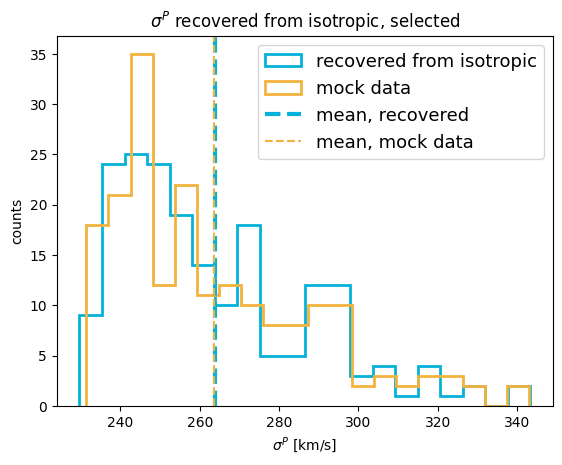

0.08971852674924093 %


In [19]:
if rerun_calculation:
    vel_disp_iso_sel = recover_vel_disp(peak_lum_sel, sigma_lum_sel, qobs_data_sel, peak_den_sel, sigma_den_sel, qobs_data_sel, inc_recover_iso_sel, distance)
mean_vel_disp_isoinc = np.mean(vel_disp_iso_sel)

plt.figure()
plt.hist(vel_disp_iso_sel, histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(sigma_e_data_sel, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_isoinc, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data_sel, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from isotropic, selected')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data_sel, mean_vel_disp_isoinc), '%')

#### The NO lensing selection sample

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.564e+13

sigma_e = 215.25 km/s
sigma_e: 215.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.126e+13

sigma_e = 234.76 km/s
sigma_e: 234.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 260.04 km/s
sigma_e: 260.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.716e+13

sigma_e = 187.08 km/s
sigma_e: 187.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 243.66 km/s
sigma_e: 243.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 263.24 km/s
sigma_e: 263.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.054e+13

sigma_e = 218.03 km/s
sigma_e: 218.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.605e+13

sigma_e = 216.06 km/s
sigma_e: 216.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.068e+14

sigma_e = 251.56 km/s
sigma_e: 251.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 234.58 km/s
sigma_e: 234.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 224.06 km/s
sigma_e: 224.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.254e+14

sigma_e = 273.24 km/s
sigma_e: 273.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 227.49 km/s
sigma_e: 227.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.710e+13

sigma_e = 225.13 km/s
sigma_e: 225.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.539e+14

sigma_e = 322.83 km/s
sigma_e: 322.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.889e+13

sigma_e = 187.61 km/s
sigma_e: 187.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 237.43 km/s
sigma_e: 237.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.077e+13

sigma_e = 141.04 km/s
sigma_e: 141.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.210e+13

sigma_e = 149.62 km/s
sigma_e: 149.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 245.52 km/s
sigma_e: 245.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.372e+14

sigma_e = 277.83 km/s
sigma_e: 277.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.566e+13

sigma_e = 208.24 km/s
sigma_e: 208.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 247.16 km/s
sigma_e: 247.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.638e+13

sigma_e = 163.79 km/s
sigma_e: 163.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 274.26 km/s
sigma_e: 274.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.459e+13

sigma_e = 252.13 km/s
sigma_e: 252.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.075e+14

sigma_e = 256.66 km/s
sigma_e: 256.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=35.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.914e+13

sigma_e = 171.70 km/s
sigma_e: 171.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 185.39 km/s
sigma_e: 185.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 263.85 km/s
sigma_e: 263.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.845e+13

sigma_e = 166.66 km/s
sigma_e: 166.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.680e+13

sigma_e = 182.24 km/s
sigma_e: 182.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.015e+14

sigma_e = 249.39 km/s
sigma_e: 249.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.124e+13

sigma_e = 216.99 km/s
sigma_e: 216.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 238.54 km/s
sigma_e: 238.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.314e+13

sigma_e = 194.82 km/s
sigma_e: 194.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.724e+14

sigma_e = 327.76 km/s
sigma_e: 327.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.131e+13

sigma_e = 173.97 km/s
sigma_e: 173.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.847e+13

sigma_e = 196.79 km/s
sigma_e: 196.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 232.55 km/s
sigma_e: 232.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.390e+13

sigma_e = 214.95 km/s
sigma_e: 214.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 245.68 km/s
sigma_e: 245.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.714e+13

sigma_e = 165.80 km/s
sigma_e: 165.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.088e+13

sigma_e = 189.44 km/s
sigma_e: 189.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.091e+13

sigma_e = 170.29 km/s
sigma_e: 170.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.597e+13

sigma_e = 159.08 km/s
sigma_e: 159.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 200.24 km/s
sigma_e: 200.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.814e+13

sigma_e = 185.76 km/s
sigma_e: 185.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 252.99 km/s
sigma_e: 252.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.886e+14

sigma_e = 300.96 km/s
sigma_e: 300.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+13

sigma_e = 153.00 km/s
sigma_e: 153.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 240.94 km/s
sigma_e: 240.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 231.67 km/s
sigma_e: 231.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.398e+13

sigma_e = 254.09 km/s
sigma_e: 254.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.680e+13

sigma_e = 158.56 km/s
sigma_e: 158.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 237.43 km/s
sigma_e: 237.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 241.50 km/s
sigma_e: 241.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.637e+13

sigma_e = 213.26 km/s
sigma_e: 213.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.816e+13

sigma_e = 199.40 km/s
sigma_e: 199.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 252.73 km/s
sigma_e: 252.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.382e+13

sigma_e = 153.42 km/s
sigma_e: 153.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.777e+13

sigma_e = 187.37 km/s
sigma_e: 187.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 218.85 km/s
sigma_e: 218.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e = 150.88 km/s
sigma_e: 150.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.599e+13

sigma_e = 233.53 km/s
sigma_e: 233.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.195e+14

sigma_e = 270.98 km/s
sigma_e: 270.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.605e+13

sigma_e = 223.95 km/s
sigma_e: 223.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.879e+13

sigma_e = 237.03 km/s
sigma_e: 237.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.464e+13

sigma_e = 155.39 km/s
sigma_e: 155.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.234e+13

sigma_e = 165.85 km/s
sigma_e: 165.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.085e+13

sigma_e = 206.57 km/s
sigma_e: 206.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.123e+13

sigma_e = 186.38 km/s
sigma_e: 186.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.738e+13

sigma_e = 257.06 km/s
sigma_e: 257.06 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.318e+13

sigma_e = 173.79 km/s
sigma_e: 173.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 200.38 km/s
sigma_e: 200.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.017e+13

sigma_e = 182.05 km/s
sigma_e: 182.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 199.68 km/s
sigma_e: 199.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.364e+14

sigma_e = 279.81 km/s
sigma_e: 279.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.882e+13

sigma_e = 170.64 km/s
sigma_e: 170.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.906e+13

sigma_e = 239.26 km/s
sigma_e: 239.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.770e+13

sigma_e = 200.01 km/s
sigma_e: 200.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 251.15 km/s
sigma_e: 251.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 291.57 km/s
sigma_e: 291.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.863e+13

sigma_e = 170.17 km/s
sigma_e: 170.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+13

sigma_e = 154.61 km/s
sigma_e: 154.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 144.45 km/s
sigma_e: 144.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 242.81 km/s
sigma_e: 242.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.272e+13

sigma_e = 191.25 km/s
sigma_e: 191.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 214.48 km/s
sigma_e: 214.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 214.41 km/s
sigma_e: 214.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.942e+13

sigma_e = 201.60 km/s
sigma_e: 201.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.154e+13

sigma_e = 205.90 km/s
sigma_e: 205.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.588e+13

sigma_e = 198.62 km/s
sigma_e: 198.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.909e+13

sigma_e = 224.30 km/s
sigma_e: 224.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.954e+12

sigma_e = 142.35 km/s
sigma_e: 142.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.863e+13

sigma_e = 196.78 km/s
sigma_e: 196.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 172.69 km/s
sigma_e: 172.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 225.70 km/s
sigma_e: 225.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 195.78 km/s
sigma_e: 195.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 231.68 km/s
sigma_e: 231.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.182e+13

sigma_e = 175.04 km/s
sigma_e: 175.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.090e+14

sigma_e = 307.86 km/s
sigma_e: 307.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.530e+13

sigma_e = 210.92 km/s
sigma_e: 210.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 224.19 km/s
sigma_e: 224.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.236e+12

sigma_e = 142.51 km/s
sigma_e: 142.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.692e+13

sigma_e = 212.75 km/s
sigma_e: 212.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.300e+13

sigma_e = 192.83 km/s
sigma_e: 192.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.660e+14

sigma_e = 292.79 km/s
sigma_e: 292.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.619e+13

sigma_e = 213.05 km/s
sigma_e: 213.05 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 197.74 km/s
sigma_e: 197.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.223e+13

sigma_e = 176.39 km/s
sigma_e: 176.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.358e+14

sigma_e = 311.15 km/s
sigma_e: 311.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.551e+13

sigma_e = 181.92 km/s
sigma_e: 181.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.692e+13

sigma_e = 163.90 km/s
sigma_e: 163.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.463e+14

sigma_e = 324.56 km/s
sigma_e: 324.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.515e+13

sigma_e = 194.04 km/s
sigma_e: 194.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.799e+13

sigma_e = 236.60 km/s
sigma_e: 236.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.239e+14

sigma_e = 271.92 km/s
sigma_e: 271.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 172.68 km/s
sigma_e: 172.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 222.54 km/s
sigma_e: 222.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.373e+13

sigma_e = 203.47 km/s
sigma_e: 203.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 220.07 km/s
sigma_e: 220.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.209e+13

sigma_e = 227.20 km/s
sigma_e: 227.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 278.03 km/s
sigma_e: 278.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.510e+13

sigma_e = 158.76 km/s
sigma_e: 158.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.099e+14

sigma_e = 255.87 km/s
sigma_e: 255.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.156e+13

sigma_e = 236.91 km/s
sigma_e: 236.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 204.21 km/s
sigma_e: 204.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.789e+13

sigma_e = 234.97 km/s
sigma_e: 234.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.88
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.923e+13

sigma_e = 216.11 km/s
sigma_e: 216.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.066e+13

sigma_e = 247.13 km/s
sigma_e: 247.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.87
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.109e+13

sigma_e = 184.45 km/s
sigma_e: 184.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.680e+13

sigma_e = 183.03 km/s
sigma_e: 183.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.380e+13

sigma_e = 215.29 km/s
sigma_e: 215.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 294.01 km/s
sigma_e: 294.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=24.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 162.45 km/s
sigma_e: 162.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 187.03 km/s
sigma_e: 187.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.325e+13

sigma_e = 151.86 km/s
sigma_e: 151.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=20.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 202.62 km/s
sigma_e: 202.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.098e+13

sigma_e = 227.78 km/s
sigma_e: 227.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 198.75 km/s
sigma_e: 198.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.802e+13

sigma_e = 209.72 km/s
sigma_e: 209.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 190.18 km/s
sigma_e: 190.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.89
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.286e+13

sigma_e = 171.29 km/s
sigma_e: 171.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 243.37 km/s
sigma_e: 243.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.573e+13

sigma_e = 192.43 km/s
sigma_e: 192.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 172.10 km/s
sigma_e: 172.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=32.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.799e+13

sigma_e = 229.32 km/s
sigma_e: 229.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.254e+13

sigma_e = 225.41 km/s
sigma_e: 225.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 208.25 km/s
sigma_e: 208.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 171.27 km/s
sigma_e: 171.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.131e+13

sigma_e = 233.90 km/s
sigma_e: 233.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 228.08 km/s
sigma_e: 228.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=26.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.627e+13

sigma_e = 243.34 km/s
sigma_e: 243.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.739e+13

sigma_e = 201.22 km/s
sigma_e: 201.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.307e+13

sigma_e = 249.96 km/s
sigma_e: 249.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.978e+13

sigma_e = 188.76 km/s
sigma_e: 188.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.101e+13

sigma_e = 165.24 km/s
sigma_e: 165.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.056e+13

sigma_e = 229.28 km/s
sigma_e: 229.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.261e+13

sigma_e = 220.40 km/s
sigma_e: 220.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.502e+13

sigma_e = 207.48 km/s
sigma_e: 207.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.096e+13

sigma_e = 240.09 km/s
sigma_e: 240.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.645e+13

sigma_e = 255.41 km/s
sigma_e: 255.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 220.52 km/s
sigma_e: 220.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 243.69 km/s
sigma_e: 243.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.223e+13

sigma_e = 142.81 km/s
sigma_e: 142.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.820e+13

sigma_e = 210.48 km/s
sigma_e: 210.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.482e+13

sigma_e = 214.50 km/s
sigma_e: 214.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 231.31 km/s
sigma_e: 231.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.528e+13

sigma_e = 172.74 km/s
sigma_e: 172.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.717e+13

sigma_e = 230.89 km/s
sigma_e: 230.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 239.75 km/s
sigma_e: 239.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.928e+13

sigma_e = 257.56 km/s
sigma_e: 257.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.879e+13

sigma_e = 201.60 km/s
sigma_e: 201.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 238.55 km/s
sigma_e: 238.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.709e+13

sigma_e = 190.80 km/s
sigma_e: 190.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.261e+13

sigma_e = 219.68 km/s
sigma_e: 219.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.259e+13

sigma_e = 190.88 km/s
sigma_e: 190.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 231.48 km/s
sigma_e: 231.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 220.24 km/s
sigma_e: 220.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.187e+13

sigma_e = 215.37 km/s
sigma_e: 215.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 213.59 km/s
sigma_e: 213.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.609e+13

sigma_e = 182.52 km/s
sigma_e: 182.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.043e+13

sigma_e = 190.70 km/s
sigma_e: 190.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.328e+13

sigma_e = 177.89 km/s
sigma_e: 177.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 200.35 km/s
sigma_e: 200.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.051e+14

sigma_e = 300.22 km/s
sigma_e: 300.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.958e+13

sigma_e = 193.65 km/s
sigma_e: 193.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 184.71 km/s
sigma_e: 184.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.618e+13

sigma_e = 199.73 km/s
sigma_e: 199.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.275e+13

sigma_e = 171.58 km/s
sigma_e: 171.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.724e+13

sigma_e = 197.73 km/s
sigma_e: 197.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.07 km/s
sigma_e: 273.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.088e+14

sigma_e = 263.08 km/s
sigma_e: 263.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 218.09 km/s
sigma_e: 218.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.837e+13

sigma_e = 223.38 km/s
sigma_e: 223.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.165e+13

sigma_e = 224.59 km/s
sigma_e: 224.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.023e+13

sigma_e = 205.16 km/s
sigma_e: 205.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.25 km/s
sigma_e: 247.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.707e+13

sigma_e = 252.53 km/s
sigma_e: 252.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.537e+13

sigma_e = 235.88 km/s
sigma_e: 235.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.761e+14

sigma_e = 290.00 km/s
sigma_e: 290.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.340e+14

sigma_e = 271.93 km/s
sigma_e: 271.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 248.99 km/s
sigma_e: 248.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.360e+14

sigma_e = 277.00 km/s
sigma_e: 277.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.529e+13

sigma_e = 191.76 km/s
sigma_e: 191.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.783e+13

sigma_e = 213.59 km/s
sigma_e: 213.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 239.77 km/s
sigma_e: 239.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.320e+13

sigma_e = 217.37 km/s
sigma_e: 217.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.630e+13

sigma_e = 163.04 km/s
sigma_e: 163.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.329e+13

sigma_e = 175.60 km/s
sigma_e: 175.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.052e+13

sigma_e = 171.47 km/s
sigma_e: 171.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.533e+14

sigma_e = 285.94 km/s
sigma_e: 285.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 187.80 km/s
sigma_e: 187.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.373e+13

sigma_e = 247.19 km/s
sigma_e: 247.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 185.03 km/s
sigma_e: 185.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.495e+13

sigma_e = 202.51 km/s
sigma_e: 202.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 240.86 km/s
sigma_e: 240.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.261e+13

sigma_e = 236.11 km/s
sigma_e: 236.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.396e+14

sigma_e = 280.35 km/s
sigma_e: 280.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.789e+13

sigma_e = 228.43 km/s
sigma_e: 228.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.845e+13

sigma_e = 164.81 km/s
sigma_e: 164.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.748e+13

sigma_e = 159.50 km/s
sigma_e: 159.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=19.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 160.87 km/s
sigma_e: 160.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.919e+13

sigma_e = 165.97 km/s
sigma_e: 165.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.095e+14

sigma_e = 262.67 km/s
sigma_e: 262.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 174.44 km/s
sigma_e: 174.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.801e+13

sigma_e = 187.01 km/s
sigma_e: 187.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.361e+13

sigma_e = 157.15 km/s
sigma_e: 157.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.965e+13

sigma_e = 171.92 km/s
sigma_e: 171.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.030e+13

sigma_e = 191.31 km/s
sigma_e: 191.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 275.00 km/s
sigma_e: 275.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 302.64 km/s
sigma_e: 302.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+14

sigma_e = 266.80 km/s
sigma_e: 266.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.783e+13

sigma_e = 163.33 km/s
sigma_e: 163.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.895e+13

sigma_e = 213.71 km/s
sigma_e: 213.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.842e+14

sigma_e = 331.42 km/s
sigma_e: 331.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.383e+13

sigma_e = 180.30 km/s
sigma_e: 180.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.412e+13

sigma_e = 158.30 km/s
sigma_e: 158.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.170e+13

sigma_e = 205.87 km/s
sigma_e: 205.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.711e+14

sigma_e = 325.74 km/s
sigma_e: 325.74 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.752e+13

sigma_e = 182.28 km/s
sigma_e: 182.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 249.48 km/s
sigma_e: 249.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.990e+13

sigma_e = 203.69 km/s
sigma_e: 203.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.810e+13

sigma_e = 168.71 km/s
sigma_e: 168.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.589e+13

sigma_e = 161.68 km/s
sigma_e: 161.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 224.51 km/s
sigma_e: 224.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.375e+13

sigma_e = 152.73 km/s
sigma_e: 152.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.280e+13

sigma_e = 218.78 km/s
sigma_e: 218.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 204.17 km/s
sigma_e: 204.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 271.15 km/s
sigma_e: 271.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 200.25 km/s
sigma_e: 200.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=23.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.329e+13

sigma_e = 174.34 km/s
sigma_e: 174.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.300e+13

sigma_e = 192.10 km/s
sigma_e: 192.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.277e+13

sigma_e = 230.17 km/s
sigma_e: 230.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 208.58 km/s
sigma_e: 208.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 256.86 km/s
sigma_e: 256.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=30.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.671e+13

sigma_e = 153.80 km/s
sigma_e: 153.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.342e+13

sigma_e = 195.22 km/s
sigma_e: 195.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.956e+13

sigma_e = 168.15 km/s
sigma_e: 168.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.513e+13

sigma_e = 209.19 km/s
sigma_e: 209.19 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.837e+13

sigma_e = 221.71 km/s
sigma_e: 221.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.965e+13

sigma_e = 186.48 km/s
sigma_e: 186.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.670e+13

sigma_e = 230.62 km/s
sigma_e: 230.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.405e+14

sigma_e = 278.97 km/s
sigma_e: 278.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.155e+14

sigma_e = 267.73 km/s
sigma_e: 267.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.814e+13

sigma_e = 188.21 km/s
sigma_e: 188.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.137e+13

sigma_e = 206.42 km/s
sigma_e: 206.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.443e+13

sigma_e = 206.60 km/s
sigma_e: 206.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.322e+13

sigma_e = 206.09 km/s
sigma_e: 206.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.388e+14

sigma_e = 278.81 km/s
sigma_e: 278.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.084e+14

sigma_e = 311.10 km/s
sigma_e: 311.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.524e+14

sigma_e = 284.50 km/s
sigma_e: 284.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.027e+13

sigma_e = 203.79 km/s
sigma_e: 203.79 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.485e+14

sigma_e = 279.41 km/s
sigma_e: 279.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 249.66 km/s
sigma_e: 249.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.765e+13

sigma_e = 165.32 km/s
sigma_e: 165.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.865e+13

sigma_e = 255.20 km/s
sigma_e: 255.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 222.02 km/s
sigma_e: 222.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.216e+13

sigma_e = 245.30 km/s
sigma_e: 245.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 217.25 km/s
sigma_e: 217.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.646e+13

sigma_e = 156.87 km/s
sigma_e: 156.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.599e+13

sigma_e = 226.65 km/s
sigma_e: 226.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 222.24 km/s
sigma_e: 222.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 220.07 km/s
sigma_e: 220.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.521e+13

sigma_e = 253.66 km/s
sigma_e: 253.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 222.00 km/s
sigma_e: 222.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.933e+14

sigma_e = 299.27 km/s
sigma_e: 299.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.037e+13

sigma_e = 246.12 km/s
sigma_e: 246.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.876e+13

sigma_e = 208.80 km/s
sigma_e: 208.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.028e+14

sigma_e = 241.63 km/s
sigma_e: 241.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.262e+14

sigma_e = 270.80 km/s
sigma_e: 270.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.891e+13

sigma_e = 170.60 km/s
sigma_e: 170.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=25.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 271.00 km/s
sigma_e: 271.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.939e+13

sigma_e = 189.34 km/s
sigma_e: 189.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 225.65 km/s
sigma_e: 225.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.300e+13

sigma_e = 220.41 km/s
sigma_e: 220.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 208.40 km/s
sigma_e: 208.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.471e+13

sigma_e = 183.51 km/s
sigma_e: 183.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 198.36 km/s
sigma_e: 198.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.948e+13

sigma_e = 251.41 km/s
sigma_e: 251.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 291.77 km/s
sigma_e: 291.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.425e+13

sigma_e = 208.76 km/s
sigma_e: 208.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 187.73 km/s
sigma_e: 187.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.281e+14

sigma_e = 267.33 km/s
sigma_e: 267.33 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.187e+14

sigma_e = 263.95 km/s
sigma_e: 263.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.142e+13

sigma_e = 228.96 km/s
sigma_e: 228.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.165e+13

sigma_e = 217.92 km/s
sigma_e: 217.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=16.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.419e+13

sigma_e = 134.13 km/s
sigma_e: 134.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.300e+14

sigma_e = 273.78 km/s
sigma_e: 273.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.901e+13

sigma_e = 183.89 km/s
sigma_e: 183.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.269e+14

sigma_e = 274.98 km/s
sigma_e: 274.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.965e+13

sigma_e = 171.78 km/s
sigma_e: 171.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.304e+14

sigma_e = 276.99 km/s
sigma_e: 276.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.880e+13

sigma_e = 219.20 km/s
sigma_e: 219.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.837e+13

sigma_e = 226.13 km/s
sigma_e: 226.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 225.98 km/s
sigma_e: 225.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.623e+13

sigma_e = 230.52 km/s
sigma_e: 230.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.70
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 203.61 km/s
sigma_e: 203.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.546e+14

sigma_e = 272.58 km/s
sigma_e: 272.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.036e+13

sigma_e = 146.32 km/s
sigma_e: 146.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.494e+13

sigma_e = 178.41 km/s
sigma_e: 178.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.221e+13

sigma_e = 211.68 km/s
sigma_e: 211.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 205.55 km/s
sigma_e: 205.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.731e+13

sigma_e = 220.11 km/s
sigma_e: 220.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.665e+14

sigma_e = 288.98 km/s
sigma_e: 288.98 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.595e+14

sigma_e = 290.27 km/s
sigma_e: 290.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.739e+13

sigma_e = 201.68 km/s
sigma_e: 201.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 268.44 km/s
sigma_e: 268.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.609e+14

sigma_e = 285.48 km/s
sigma_e: 285.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.655e+14

sigma_e = 267.27 km/s
sigma_e: 267.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.752e+13

sigma_e = 179.73 km/s
sigma_e: 179.73 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.217e+13

sigma_e = 195.26 km/s
sigma_e: 195.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.104e+13

sigma_e = 213.16 km/s
sigma_e: 213.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.254e+13

sigma_e = 202.63 km/s
sigma_e: 202.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.523e+13

sigma_e = 213.10 km/s
sigma_e: 213.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.752e+13

sigma_e = 219.96 km/s
sigma_e: 219.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.227e+14

sigma_e = 317.09 km/s
sigma_e: 317.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.970e+13

sigma_e = 208.45 km/s
sigma_e: 208.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.342e+13

sigma_e = 194.76 km/s
sigma_e: 194.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.007e+14

sigma_e = 340.92 km/s
sigma_e: 340.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 207.95 km/s
sigma_e: 207.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.030e+13

sigma_e = 144.51 km/s
sigma_e: 144.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.966e+13

sigma_e = 226.92 km/s
sigma_e: 226.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.88
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.299e+13

sigma_e = 216.40 km/s
sigma_e: 216.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 180.18 km/s
sigma_e: 180.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.836e+13

sigma_e = 167.54 km/s
sigma_e: 167.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.286e+13

sigma_e = 193.32 km/s
sigma_e: 193.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.668e+13

sigma_e = 184.40 km/s
sigma_e: 184.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.909e+13

sigma_e = 167.67 km/s
sigma_e: 167.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.989e+13

sigma_e = 214.47 km/s
sigma_e: 214.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.802e+13

sigma_e = 250.50 km/s
sigma_e: 250.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.062e+13

sigma_e = 171.68 km/s
sigma_e: 171.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.449e+13

sigma_e = 175.88 km/s
sigma_e: 175.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.490e+13

sigma_e = 255.89 km/s
sigma_e: 255.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.081e+13

sigma_e = 236.64 km/s
sigma_e: 236.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.007e+13

sigma_e = 235.29 km/s
sigma_e: 235.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.889e+13

sigma_e = 222.46 km/s
sigma_e: 222.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 240.63 km/s
sigma_e: 240.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.296e+14

sigma_e = 271.90 km/s
sigma_e: 271.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.007e+13

sigma_e = 247.68 km/s
sigma_e: 247.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 225.13 km/s
sigma_e: 225.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.825e+13

sigma_e = 238.21 km/s
sigma_e: 238.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.70
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.266e+14

sigma_e = 266.54 km/s
sigma_e: 266.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.130e+14

sigma_e = 260.75 km/s
sigma_e: 260.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.765e+13

sigma_e = 166.92 km/s
sigma_e: 166.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.70
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.205e+13

sigma_e = 232.32 km/s
sigma_e: 232.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.839e+13

sigma_e = 207.12 km/s
sigma_e: 207.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.507e+14

sigma_e = 284.80 km/s
sigma_e: 284.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.794e+13

sigma_e = 222.12 km/s
sigma_e: 222.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.951e+13

sigma_e = 215.99 km/s
sigma_e: 215.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.727e+14

sigma_e = 297.18 km/s
sigma_e: 297.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.041e+14

sigma_e = 255.89 km/s
sigma_e: 255.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 229.66 km/s
sigma_e: 229.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.552e+13

sigma_e = 254.51 km/s
sigma_e: 254.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.169e+14

sigma_e = 263.00 km/s
sigma_e: 263.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.449e+13

sigma_e = 157.95 km/s
sigma_e: 157.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.442e+13

sigma_e = 198.63 km/s
sigma_e: 198.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.426e+13

sigma_e = 157.69 km/s
sigma_e: 157.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.544e+13

sigma_e = 196.27 km/s
sigma_e: 196.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.072e+13

sigma_e = 168.63 km/s
sigma_e: 168.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=38.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.827e+13

sigma_e = 161.28 km/s
sigma_e: 161.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.401e+13

sigma_e = 245.03 km/s
sigma_e: 245.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.139e+13

sigma_e = 148.67 km/s
sigma_e: 148.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.91 km/s
sigma_e: 246.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.058e+14

sigma_e = 258.50 km/s
sigma_e: 258.50 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.479e+13

sigma_e = 159.89 km/s
sigma_e: 159.89 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.314e+13

sigma_e = 189.93 km/s
sigma_e: 189.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.707e+14

sigma_e = 294.54 km/s
sigma_e: 294.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.928e+13

sigma_e = 164.65 km/s
sigma_e: 164.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.350e+13

sigma_e = 165.64 km/s
sigma_e: 165.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.380e+14

sigma_e = 272.80 km/s
sigma_e: 272.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.792e+13

sigma_e = 162.45 km/s
sigma_e: 162.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.861e+13

sigma_e = 228.83 km/s
sigma_e: 228.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 233.66 km/s
sigma_e: 233.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 220.23 km/s
sigma_e: 220.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.203e+13

sigma_e = 205.62 km/s
sigma_e: 205.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.551e+14

sigma_e = 283.69 km/s
sigma_e: 283.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.633e+13

sigma_e = 196.34 km/s
sigma_e: 196.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.096e+13

sigma_e = 179.52 km/s
sigma_e: 179.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.981e+14

sigma_e = 296.45 km/s
sigma_e: 296.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.237e+13

sigma_e = 207.39 km/s
sigma_e: 207.39 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.754e+13

sigma_e = 198.01 km/s
sigma_e: 198.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.104e+13

sigma_e = 211.67 km/s
sigma_e: 211.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.589e+13

sigma_e = 161.92 km/s
sigma_e: 161.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.766e+14

sigma_e = 293.63 km/s
sigma_e: 293.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.065e+14

sigma_e = 262.45 km/s
sigma_e: 262.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.237e+13

sigma_e = 207.09 km/s
sigma_e: 207.09 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.548e+13

sigma_e = 209.08 km/s
sigma_e: 209.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.552e+13

sigma_e = 229.36 km/s
sigma_e: 229.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 231.08 km/s
sigma_e: 231.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.622e+13

sigma_e = 163.77 km/s
sigma_e: 163.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.574e+13

sigma_e = 183.32 km/s
sigma_e: 183.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 180.81 km/s
sigma_e: 180.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.112e+14

sigma_e = 292.26 km/s
sigma_e: 292.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.597e+13

sigma_e = 157.69 km/s
sigma_e: 157.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 214.25 km/s
sigma_e: 214.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.372e+13

sigma_e = 170.28 km/s
sigma_e: 170.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 257.70 km/s
sigma_e: 257.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=21.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 143.70 km/s
sigma_e: 143.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 199.28 km/s
sigma_e: 199.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 310.48 km/s
sigma_e: 310.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.576e+13

sigma_e = 230.99 km/s
sigma_e: 230.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=73.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 240.64 km/s
sigma_e: 240.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 244.38 km/s
sigma_e: 244.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 172.47 km/s
sigma_e: 172.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.937e+13

sigma_e = 166.31 km/s
sigma_e: 166.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.833e+13

sigma_e = 250.11 km/s
sigma_e: 250.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.091e+13

sigma_e = 174.18 km/s
sigma_e: 174.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=31.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 247.18 km/s
sigma_e: 247.18 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.356e+13

sigma_e = 207.58 km/s
sigma_e: 207.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.452e+12

sigma_e = 138.22 km/s
sigma_e: 138.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.958e+13

sigma_e = 236.70 km/s
sigma_e: 236.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.537e+13

sigma_e = 231.71 km/s
sigma_e: 231.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.337e+13

sigma_e = 249.28 km/s
sigma_e: 249.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.85
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.206e+13

sigma_e = 241.26 km/s
sigma_e: 241.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.042e+13

sigma_e = 173.45 km/s
sigma_e: 173.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.459e+13

sigma_e = 230.78 km/s
sigma_e: 230.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.229e+13

sigma_e = 151.80 km/s
sigma_e: 151.80 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.273e+14

sigma_e = 270.55 km/s
sigma_e: 270.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.792e+13

sigma_e = 167.93 km/s
sigma_e: 167.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.009e+14

sigma_e = 255.66 km/s
sigma_e: 255.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.566e+13

sigma_e = 202.67 km/s
sigma_e: 202.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.413e+14

sigma_e = 265.76 km/s
sigma_e: 265.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.740e+13

sigma_e = 180.54 km/s
sigma_e: 180.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.746e+13

sigma_e = 235.61 km/s
sigma_e: 235.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=36.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 210.61 km/s
sigma_e: 210.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.958e+13

sigma_e = 205.56 km/s
sigma_e: 205.56 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.032e+13

sigma_e = 222.15 km/s
sigma_e: 222.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.309e+14

sigma_e = 315.54 km/s
sigma_e: 315.54 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.618e+13

sigma_e = 189.57 km/s
sigma_e: 189.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.180e+13

sigma_e = 234.68 km/s
sigma_e: 234.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.120e+13

sigma_e = 149.75 km/s
sigma_e: 149.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.041e+13

sigma_e = 237.62 km/s
sigma_e: 237.62 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.482e+13

sigma_e = 225.96 km/s
sigma_e: 225.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.101e+13

sigma_e = 165.82 km/s
sigma_e: 165.82 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.774e+13

sigma_e = 167.13 km/s
sigma_e: 167.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.515e+14

sigma_e = 286.86 km/s
sigma_e: 286.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 220.96 km/s
sigma_e: 220.96 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 245.10 km/s
sigma_e: 245.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.731e+13

sigma_e = 152.60 km/s
sigma_e: 152.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.626e+13

sigma_e = 219.22 km/s
sigma_e: 219.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.562e+13

sigma_e = 237.78 km/s
sigma_e: 237.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.306e+13

sigma_e = 237.76 km/s
sigma_e: 237.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.198e+14

sigma_e = 270.77 km/s
sigma_e: 270.77 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.743e+13

sigma_e = 247.11 km/s
sigma_e: 247.11 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.328e+13

sigma_e = 188.91 km/s
sigma_e: 188.91 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.626e+13

sigma_e = 223.07 km/s
sigma_e: 223.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.832e+13

sigma_e = 204.07 km/s
sigma_e: 204.07 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.368e+13

sigma_e = 155.47 km/s
sigma_e: 155.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.614e+14

sigma_e = 292.03 km/s
sigma_e: 292.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 244.66 km/s
sigma_e: 244.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.186e+13

sigma_e = 244.85 km/s
sigma_e: 244.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.622e+13

sigma_e = 162.84 km/s
sigma_e: 162.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.994e+13

sigma_e = 169.95 km/s
sigma_e: 169.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=83.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.413e+13

sigma_e = 223.14 km/s
sigma_e: 223.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.162e+13

sigma_e = 176.38 km/s
sigma_e: 176.38 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.029e+14

sigma_e = 291.10 km/s
sigma_e: 291.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.544e+13

sigma_e = 197.70 km/s
sigma_e: 197.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.182e+13

sigma_e = 170.13 km/s
sigma_e: 170.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.934e+13

sigma_e = 235.58 km/s
sigma_e: 235.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.265e+13

sigma_e = 164.40 km/s
sigma_e: 164.40 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.619e+13

sigma_e = 213.32 km/s
sigma_e: 213.32 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.209e+13

sigma_e = 223.02 km/s
sigma_e: 223.02 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.118e+14

sigma_e = 306.81 km/s
sigma_e: 306.81 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.394e+13

sigma_e = 178.83 km/s
sigma_e: 178.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.678e+13

sigma_e = 197.23 km/s
sigma_e: 197.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.046e+13

sigma_e = 209.04 km/s
sigma_e: 209.04 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.472e+13

sigma_e = 160.24 km/s
sigma_e: 160.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.010e+13

sigma_e = 226.70 km/s
sigma_e: 226.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.772e+13

sigma_e = 233.31 km/s
sigma_e: 233.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.441e+13

sigma_e = 221.27 km/s
sigma_e: 221.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.777e+13

sigma_e = 172.25 km/s
sigma_e: 172.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.367e+13

sigma_e = 252.93 km/s
sigma_e: 252.93 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.345e+13

sigma_e = 221.94 km/s
sigma_e: 221.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.014e+13

sigma_e = 244.75 km/s
sigma_e: 244.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.006e+14

sigma_e = 257.25 km/s
sigma_e: 257.25 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.187e+13

sigma_e = 220.08 km/s
sigma_e: 220.08 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.863e+13

sigma_e = 198.68 km/s
sigma_e: 198.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.332e+13

sigma_e = 153.64 km/s
sigma_e: 153.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.586e+13

sigma_e = 180.24 km/s
sigma_e: 180.24 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.551e+13

sigma_e = 180.61 km/s
sigma_e: 180.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.913e+13

sigma_e = 212.26 km/s
sigma_e: 212.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.83
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=33.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.449e+13

sigma_e = 167.22 km/s
sigma_e: 167.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.055e+14

sigma_e = 256.76 km/s
sigma_e: 256.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.86
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=42.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.354e+13

sigma_e = 148.87 km/s
sigma_e: 148.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 242.17 km/s
sigma_e: 242.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.436e+13

sigma_e = 229.30 km/s
sigma_e: 229.30 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 226.60 km/s
sigma_e: 226.60 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=39.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.703e+14

sigma_e = 285.85 km/s
sigma_e: 285.85 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.820e+13

sigma_e = 215.68 km/s
sigma_e: 215.68 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=82.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.866e+14

sigma_e = 289.37 km/s
sigma_e: 289.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 246.69 km/s
sigma_e: 246.69 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.974e+13

sigma_e = 203.01 km/s
sigma_e: 203.01 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 243.65 km/s
sigma_e: 243.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.694e+13

sigma_e = 232.86 km/s
sigma_e: 232.86 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.584e+13

sigma_e = 211.29 km/s
sigma_e: 211.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.245e+13

sigma_e = 186.48 km/s
sigma_e: 186.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=60.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.176e+13

sigma_e = 188.37 km/s
sigma_e: 188.37 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=71.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.241e+13

sigma_e = 206.71 km/s
sigma_e: 206.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.055e+13

sigma_e = 206.90 km/s
sigma_e: 206.90 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.836e+13

sigma_e = 166.26 km/s
sigma_e: 166.26 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.876e+13

sigma_e = 216.13 km/s
sigma_e: 216.13 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=78.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.019e+14

sigma_e = 256.84 km/s
sigma_e: 256.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.860e+13

sigma_e = 246.34 km/s
sigma_e: 246.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.751e+14

sigma_e = 294.42 km/s
sigma_e: 294.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=74.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.277e+14

sigma_e = 272.46 km/s
sigma_e: 272.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.408e+13

sigma_e = 199.70 km/s
sigma_e: 199.70 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=55.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.056e+13

sigma_e = 191.28 km/s
sigma_e: 191.28 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.960e+13

sigma_e = 230.31 km/s
sigma_e: 230.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.644e+13

sigma_e = 178.87 km/s
sigma_e: 178.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=49.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.526e+13

sigma_e = 155.78 km/s
sigma_e: 155.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=63.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.456e+13

sigma_e = 186.36 km/s
sigma_e: 186.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=68.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.977e+13

sigma_e = 246.72 km/s
sigma_e: 246.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.148e+14

sigma_e = 259.78 km/s
sigma_e: 259.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=34.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.614e+13

sigma_e = 230.63 km/s
sigma_e: 230.63 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.083e+13

sigma_e = 148.03 km/s
sigma_e: 148.03 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.286e+13

sigma_e = 175.99 km/s
sigma_e: 175.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.852e+13

sigma_e = 241.17 km/s
sigma_e: 241.17 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.978e+13

sigma_e = 184.29 km/s
sigma_e: 184.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.802e+13

sigma_e = 205.57 km/s
sigma_e: 205.57 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=46.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.728e+13

sigma_e = 200.53 km/s
sigma_e: 200.53 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.123e+13

sigma_e = 244.49 km/s
sigma_e: 244.49 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.123e+13

sigma_e = 190.99 km/s
sigma_e: 190.99 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=61.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.895e+13

sigma_e = 204.15 km/s
sigma_e: 204.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=64.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.710e+13

sigma_e = 217.16 km/s
sigma_e: 217.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.574e+13

sigma_e = 183.31 km/s
sigma_e: 183.31 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=70.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.442e+13

sigma_e = 197.59 km/s
sigma_e: 197.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.143e+13

sigma_e = 215.88 km/s
sigma_e: 215.88 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.991e+13

sigma_e = 186.64 km/s
sigma_e: 186.64 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.668e+13

sigma_e = 185.42 km/s
sigma_e: 185.42 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.013e+13

sigma_e = 173.15 km/s
sigma_e: 173.15 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=37.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.390e+13

sigma_e = 207.58 km/s
sigma_e: 207.58 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.460e+13

sigma_e = 182.00 km/s
sigma_e: 182.00 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=41.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.602e+13

sigma_e = 198.16 km/s
sigma_e: 198.16 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=58.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.552e+13

sigma_e = 228.71 km/s
sigma_e: 228.71 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=54.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.382e+13

sigma_e = 234.36 km/s
sigma_e: 234.36 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.515e+13

sigma_e = 190.59 km/s
sigma_e: 190.59 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=81.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.970e+13

sigma_e = 216.84 km/s
sigma_e: 216.84 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=67.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.170e+13

sigma_e = 206.41 km/s
sigma_e: 206.41 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.004e+13

sigma_e = 190.52 km/s
sigma_e: 190.52 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=69.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.543e+13

sigma_e = 223.55 km/s
sigma_e: 223.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=76.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.774e+13

sigma_e = 167.51 km/s
sigma_e: 167.51 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.818e+13

sigma_e = 161.47 km/s
sigma_e: 161.47 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=27.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.210e+13

sigma_e = 140.35 km/s
sigma_e: 140.35 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=75.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.588e+13

sigma_e = 197.22 km/s
sigma_e: 197.22 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.80
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.428e+13

sigma_e = 174.65 km/s
sigma_e: 174.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.068e+13

sigma_e = 233.78 km/s
sigma_e: 233.78 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=87.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.113e+14

sigma_e = 249.48 km/s
sigma_e: 249.48 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=80.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.421e+13

sigma_e = 222.10 km/s
sigma_e: 222.10 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=53.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.202e+13

sigma_e = 214.65 km/s
sigma_e: 214.65 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=29.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.584e+13

sigma_e = 204.12 km/s
sigma_e: 204.12 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=66.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.012e+14

sigma_e = 247.23 km/s
sigma_e: 247.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=56.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.901e+13

sigma_e = 184.45 km/s
sigma_e: 184.45 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.320e+13

sigma_e = 218.61 km/s
sigma_e: 218.61 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.628e+14

sigma_e = 270.20 km/s
sigma_e: 270.20 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=48.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.559e+13

sigma_e = 194.75 km/s
sigma_e: 194.75 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.876e+13

sigma_e = 184.83 km/s
sigma_e: 184.83 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=57.9; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.704e+13

sigma_e = 185.29 km/s
sigma_e: 185.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=50.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.297e+14

sigma_e = 295.92 km/s
sigma_e: 295.92 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=72.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 4.104e+13

sigma_e = 207.29 km/s
sigma_e: 207.29 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=44.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.901e+13

sigma_e = 221.72 km/s
sigma_e: 221.72 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=43.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.773e+13

sigma_e = 216.44 km/s
sigma_e: 216.44 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=65.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.945e+13

sigma_e = 214.66 km/s
sigma_e: 214.66 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=89.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 5.143e+13

sigma_e = 219.21 km/s
sigma_e: 219.21 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.84
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.046e+14

sigma_e = 301.23 km/s
sigma_e: 301.23 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.78
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.173e+14

sigma_e = 259.97 km/s
sigma_e: 259.97 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=86.8; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.307e+13

sigma_e = 175.67 km/s
sigma_e: 175.67 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=51.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.731e+13

sigma_e = 165.87 km/s
sigma_e: 165.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=88.2; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.485e+13

sigma_e = 246.76 km/s
sigma_e: 246.76 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=84.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.485e+13

sigma_e = 196.43 km/s
sigma_e: 196.43 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=85.4; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.368e+13

sigma_e = 231.34 km/s
sigma_e: 231.34 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=47.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 7.434e+13

sigma_e = 236.55 km/s
sigma_e: 236.55 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.81
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=52.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.178e+13

sigma_e = 243.87 km/s
sigma_e: 243.87 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.72
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=59.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.133e+14

sigma_e = 343.27 km/s
sigma_e: 343.27 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=77.6; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.960e+13

sigma_e = 256.95 km/s
sigma_e: 256.95 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=45.5; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.457e+13

sigma_e = 232.14 km/s
sigma_e: 232.14 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=28.1; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.277e+13

sigma_e = 210.94 km/s
sigma_e: 210.94 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=62.3; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.603e+13

sigma_e = 197.46 km/s
sigma_e: 197.46 km/s


jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.74
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=79.7; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 1.618e+14

sigma_e = 291.11 km/s
sigma_e: 291.11 km/s


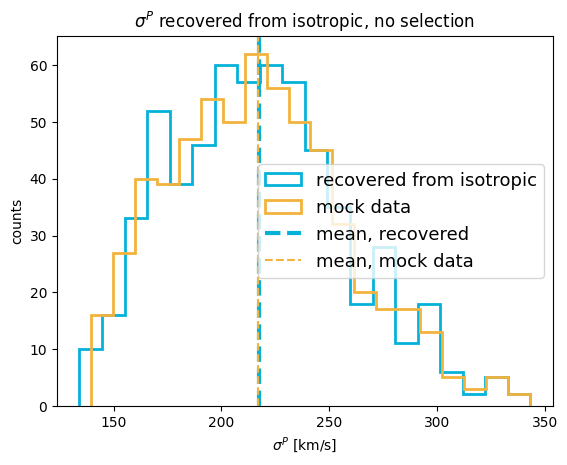

0.16141568725217725 %


In [20]:
if rerun_calculation:
    vel_disp_iso_all = recover_vel_disp(peak_lum, sigma_lum, qobs_data, peak_den, sigma_den, qobs_data, inc_recover_iso_all, distance)
mean_vel_disp_isoinc_no_sel = np.mean(vel_disp_iso_all)

plt.figure()
plt.hist(vel_disp_iso_all, histtype='step', lw = 2, label = 'recovered from isotropic', bins=20)
plt.hist(sigma_e_data, histtype='step', lw = 2, label = 'mock data', bins=20)
plt.axvline(mean_vel_disp_isoinc_no_sel, marker = ' ', ls = '--', label = 'mean, recovered', color = clist[0], lw=3)
plt.axvline(mean_sigma_e_data, marker = ' ', ls = '--', label = 'mean, mock data', color = clist[1])
plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('counts')
plt.title(r'$\sigma^P$ recovered from isotropic, no selection')
plt.legend(prop = {'size': 13})
plt.show()

print(percent_diff(mean_sigma_e_data, mean_vel_disp_isoinc_no_sel), '%')

## save data

In [21]:
if rerun_calculation:   
    with h5py.File('./kin_recovery_axisym_{}.hdf5' .format(oblate_name), 'w') as f:
        f.create_dataset(name='inc_recover_all', data = inc_recover_all)
        f.create_dataset(name='inc_recover_iso_all', data = inc_recover_iso_all)
        f.create_dataset(name='vel_disp_all', data = vel_disp_all)
        f.create_dataset(name='vel_disp_iso_all', data = vel_disp_iso_all)
        f.create_dataset(name='inc_recover_sel', data = inc_recover_sel)
        f.create_dataset(name='inc_recover_iso_sel', data = inc_recover_iso_sel)
        f.create_dataset(name='vel_disp_sel', data = vel_disp_sel)
        f.create_dataset(name='vel_disp_iso_sel', data = vel_disp_iso_sel)

In [22]:
def percent_err(x, x_ref):
    return (x - x_ref) / x_ref * 100

/tmp/ipykernel_2486233/3768489508.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


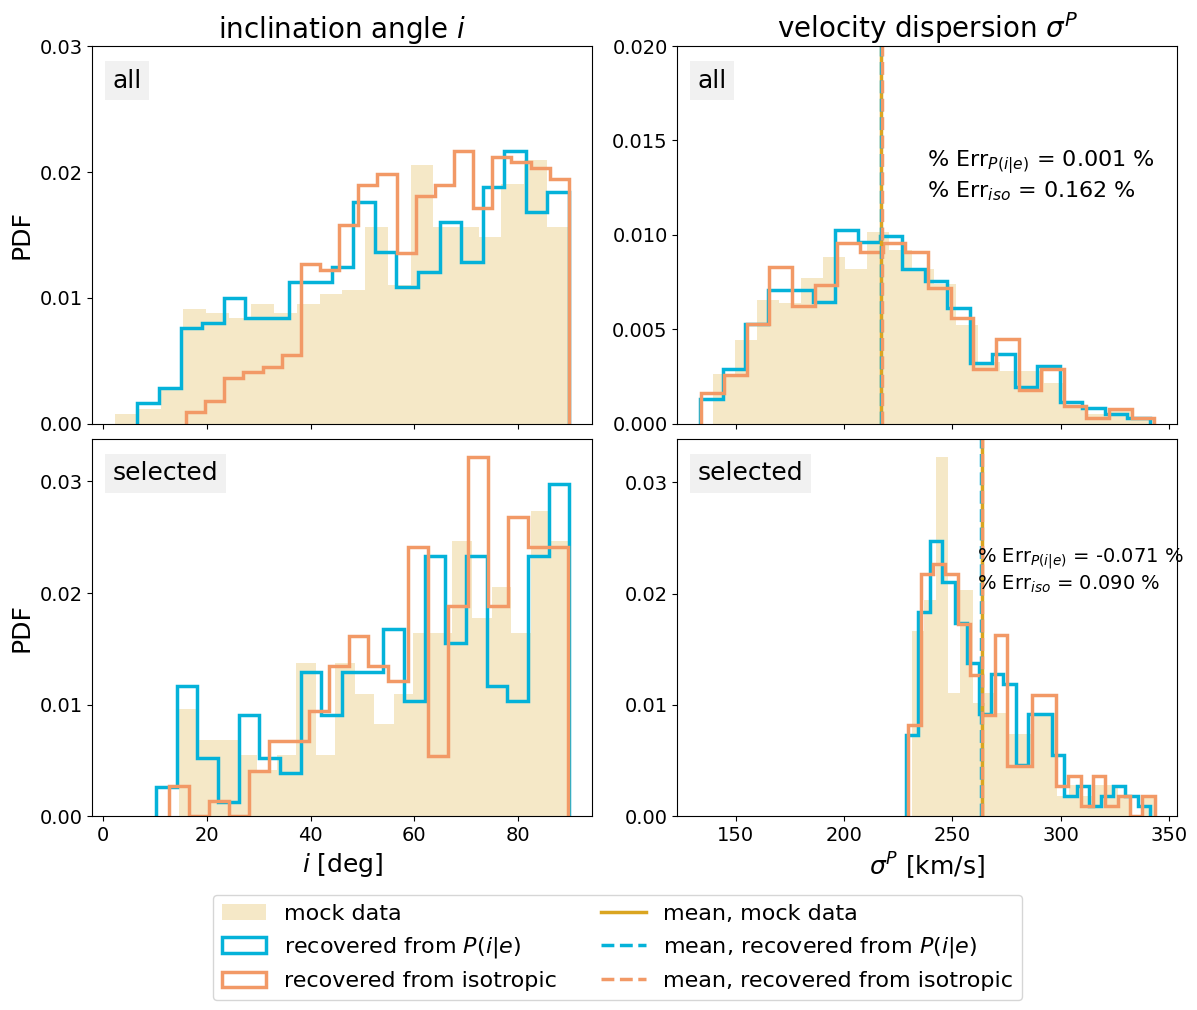

In [23]:
# Create a figure and a grid of subplots
fig = plt.figure(figsize = (14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.04, wspace = 0.17)
axs = gs.subplots(sharex='col')

color_pie = clist[0]
color_iso = clist[2]
color_data = 'goldenrod'

lw_hist = 2.5

# plot the (0, 0) subplot
axs[0, 0].hist(np.degrees(inc_recover_all), bins=20, label = r'recovered from $P(i\vert e)$', histtype='step', lw = lw_hist, density=True, color=color_pie)
axs[0, 0].hist(np.degrees(inc_recover_iso_all), bins=20, label = 'recovered from isotropic', histtype='step', lw = lw_hist, density=True, color=color_iso)
axs[0, 0].hist(inc_data, bins = 20, label = 'mock data', alpha = 0.25, density=True, color=color_data)
# set labels
axs[0, 0].set_xlabel('$i$ [deg]')
axs[0, 0].set_ylabel('PDF')
axs[0, 0].label_outer()
# axs[0, 0].sharey(axs[1, 0])
axs[0, 0].set_yticks(np.arange(0, 0.038, 0.01))
axs[0, 0].set_title('inclination angle $i$', fontsize=20)
# axs[0, 0].text(-45, 0.017, 'No \n selection', horizontalalignment='center', verticalalignment='center', fontsize=26)

# plot the (0, 1) subplot
axs[0, 1].hist(vel_disp_all, histtype='step', lw = lw_hist, label = r'recovered from $P(i\vert e)$', bins=20, density=True, color=color_pie)
axs[0, 1].hist(vel_disp_iso_all, histtype='step', lw = lw_hist, label = 'recovered from isotropic', bins=20, density=True, color=color_iso)
axs[0, 1].hist(sigma_e_data, alpha = 0.25, label = 'mock data', bins=20, density=True, color=color_data)
# plot the mean values
axs[0, 1].axvline(mean_sigma_e_data, marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)
axs[0, 1].axvline(mean_vel_disp_no_sel, marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)
axs[0, 1].axvline(mean_vel_disp_isoinc_no_sel, marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)
# set labels
# axs[0, 1].set_ylabel('PDF')
# axs[0, 1].sharey(axs[1, 1])
axs[0, 1].set_yticks(np.arange(0, 0.025, 0.005))
axs[0, 1].set_title(r'velocity dispersion $\sigma^P$', fontsize=20)
axs[0, 1].text(0.5, 0.6, s = r'% Err$_{P(i\vert e)}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_no_sel, mean_sigma_e_data)) +'\n' + r'% Err$_{iso}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_isoinc_no_sel, mean_sigma_e_data)), fontsize=16, transform = axs[0, 1].transAxes)

# plot the (1, 0) subplot
axs[1, 0].hist(np.degrees(inc_recover_sel), bins=20, histtype='step', label = r'recovered from $P(i\vert e)$', lw = lw_hist, density=True, color = color_pie)
axs[1, 0].hist(np.degrees(inc_recover_iso_sel), bins=20, histtype='step', label = 'recovered from isotropic', lw = lw_hist, density=True, color=color_iso)
axs[1, 0].hist(inc_data_sel, bins = 20, label='mock data', alpha = 0.25, density=True, color = color_data)
# set labels
axs[1, 0].set_xlabel('$i$ [deg]')
axs[1, 0].set_ylabel('PDF')
axs[1, 0].label_outer()
axs[1, 0].set_yticks(np.arange(0, 0.04, 0.01))
# axs[1, 0].text(-45, 0.017, 'With \n selection', horizontalalignment='center', verticalalignment='center', fontsize=26)


# plot the (1, 1) subplot
axs[1, 1].hist(vel_disp_sel, histtype='step', lw = lw_hist, label = r'recovered from $P(i\vert e)$', bins=20, density=True, color=color_pie)
axs[1, 1].hist(vel_disp_iso_sel, histtype='step', lw = lw_hist, label = 'recovered from isotropic', bins=20, density=True, color=color_iso)
axs[1, 1].hist(sigma_e_data_sel, alpha = 0.25, label = 'mock data', bins=20, density=True, color=color_data)
# plot the mean values
axs[1, 1].axvline(mean_sigma_e_data_sel, marker = ' ', ls = '-', label = 'mean, mock data', color=color_data, lw=lw_hist)
axs[1, 1].axvline(mean_vel_disp_sel, marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)
axs[1, 1].axvline(mean_vel_disp_isoinc, marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)
# set label
axs[1, 1].set_xlabel(r'$\sigma^P$ [km/s]')
axs[1, 1].set_yticks(np.arange(0, 0.038, 0.01))
# axs[1, 1].set_ylabel('PDF')
# annotate percent error
axs[1, 1].text(0.6, 0.6, s = r'% Err$_{P(i\vert e)}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_sel, mean_sigma_e_data_sel)) +'\n' + r'% Err$_{iso}$'+' = {:.3f} %' .format(percent_err(mean_vel_disp_isoinc, mean_sigma_e_data_sel)), fontsize=14, transform = axs[1, 1].transAxes)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# adjust axis label size
for ax in axs.flatten():
    ax.xaxis.label.set(fontsize=18)
    ax.yaxis.label.set(fontsize=18)
    ax.tick_params(axis='both', labelsize = 14)

# plot some dummy plots for legend making
dummy_labels = []
dummy_labels.append(patches.Patch(edgecolor='none', facecolor=color_data, label='mock data', alpha = 0.25))
dummy_labels.append(patches.Patch(edgecolor=color_pie, facecolor='none', label=r'recovered from $P(i\vert e)$', lw=lw_hist))
dummy_labels.append(patches.Patch(edgecolor=color_iso, facecolor='none', label='recovered from isotropic', lw=lw_hist))
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '-', label = 'mean, mock data', color = color_data, lw=lw_hist)[0])
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '--', label = r'mean, recovered from $P(i\vert e)$', color = color_pie, lw=lw_hist)[0])
dummy_labels.append(axs[1, 1].plot([], [], marker = ' ', ls = '--', label = 'mean, recovered from isotropic', color = color_iso, lw=lw_hist)[0])

fig.legend(handles=dummy_labels, loc='lower center', bbox_to_anchor=(0.5, -0.085), ncol=2, fontsize=16)

# annotate the with or without lensing selection
props = dict(boxstyle = 'square', facecolor = 'lightgray', alpha = 0.3, edgecolor = 'None')
for ax in axs[0]:
    ax.text(0.04, 0.89, 'all', transform = ax.transAxes, fontsize = 18, bbox=props)
for ax in axs[1]:
    ax.text(0.04, 0.89, 'selected', transform = ax.transAxes, fontsize = 18, bbox=props)

# plt.savefig('./kin_recovery_{}.pdf' .format(oblate_name), bbox_inches='tight', dpi=300)

plt.show()